# Tutorial on single-cell trajectory alignment using Genes2Genes

G2G aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison.

In [1]:
import matplotlib.pyplot as plt
import gseapy as gp

def GO_plot(gene_list, gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'GO_Biological_Process_2023', 'Reactome_2022'], 
            display_table=False, title_suffix=None, sort_by='Combined Score', n_rank = 10, n_genes=None, FDR=None):
    """
    Generate GO plots and optionally display tables based on enrichment analysis.

    Parameters:
    - gene_list: List of gene names as strings
    - gene_sets: List of gene set names as strings
    - display_table: Boolean flag to display table or not
    - title_suffix: Suffix for the plot title
    - sort_by: Column name to sort the results and plot. Other options in table, e.g. 'n_genes'
    - n_rank: number of terms to include in plot
    """
    
    # Perform enrichment analysis
    enr_res = gp.enrichr(gene_list=gene_list,
                         gene_sets=gene_sets,
                         organism='human',
                         outdir=None)
    
    # Loop through each gene set to process and plot the results
    for geneset in gene_sets:
        print(geneset)
        
        # Filter the results based on the Gene_set
        df = enr_res.results[enr_res.results['Gene_set'] == geneset]
        
        # Calculate the number of genes in the overlap and add as a new column
        df['n_genes'] = [int(x.split('/')[0]) for x in df['Overlap']]
        
        # Sort the dataframe based on the specified column
        df = df.sort_values(sort_by, ascending=False)

        # Only use terms where a threshold number of genes are present
        if n_rank is not None:
            df = df[df.n_genes>=n_genes]

        if FDR is not None:
            df = df[df['Adjusted P-value']<FDR]
        
        # Optionally display the table
        if display_table:
            display(df[:30])
        
        # Generate the bar plot for the top 10 ranked terms
        plt.rcParams['axes.grid'] = False
        plt.rcParams['figure.figsize'] = 4, 3
        plt.barh(width=df[:n_rank][sort_by],
                 y=[x.split(' (')[0] for x in df[:n_rank]['Term']],
                 color='darkred')
        plt.gca().invert_yaxis()
        plt.xlabel(sort_by)
        if title_suffix:
            plt.title(f'{geneset}_{title_suffix}')
        else:
            plt.title(f'{geneset}')
        plt.margins(y=0.02)
        plt.show()
        
    return df

In [2]:
import anndata

def split_adata_by_modality(adata, modality_column, modality_values):
    """
    Splits an AnnData object into multiple AnnData objects based on a given modality column.
    
    Parameters:
        adata (anndata.AnnData): The original AnnData object.
        modality_column (str): The name of the column in adata.var that contains the modality information.
        modality_values (list): List of unique modalities that you want to split the adata into.
        
    Returns:
        dict: A dictionary where the keys are the modality names and the values are the new AnnData objects.
    """
    # Initialize an empty dictionary to hold the new AnnData objects
    splitted_adatas = {}
    
    # Loop through each modality value to create a new AnnData object
    for modality in modality_values:
        # Get the indices of the features belonging to the current modality
        feature_idx = adata.var[modality_column] == modality
        
        # Create a new AnnData object with only the features belonging to the current modality
        new_adata = anndata.AnnData(X=adata[:, feature_idx].X,
                                    obs=adata.obs,
                                    var=adata.var.loc[feature_idx],
                                    obsm=adata.obsm,
                                    uns=adata.uns)
        
        # Add the new AnnData object to the dictionary
        splitted_adatas[modality] = new_adata
    
    return splitted_adatas

In [3]:
import scanpy as sc
import anndata
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import platform
from optbinning import ContinuousOptimalBinning
import pandas as pd


from genes2genes import Main
from genes2genes import VisualUtils
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyserV2

print(platform.python_version())

3.8.18


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Load the reference and query anndata objects

In [5]:
temporal_ordering='age_days_smoothed_once'

In [6]:
paired_adata_with_time_path = "/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA/aCMs_WholeSample_paired_with_time.h5ad"

In [7]:
adata=sc.read(paired_adata_with_time_path)
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', 'milesto

In [8]:
adata.obs["time"]=adata.obs['t'].copy()

In [9]:
adata.X.data[:5]

array([2., 1., 1., 1., 1.], dtype=float32)

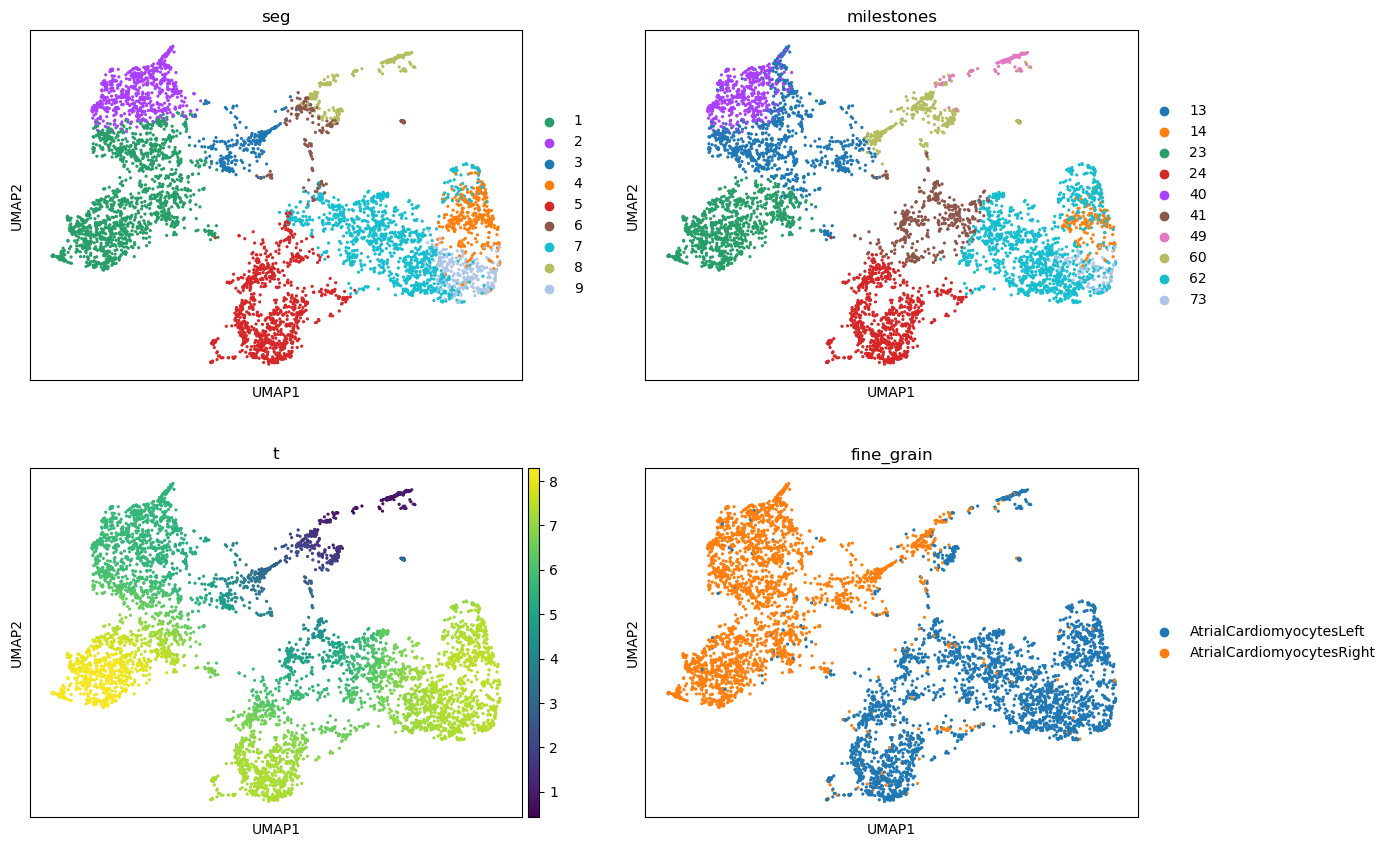

In [10]:
sc.pl.umap(adata,color=["seg","milestones","t","fine_grain"],ncols=2)

In [11]:
modality_column = "modality"
modality_values = ["Gene Expression", "Peaks"]
splitted_adatas = split_adata_by_modality(adata, modality_column, modality_values)

adata_gex = splitted_adatas["Gene Expression"]
print(adata_gex)

adata_atac = splitted_adatas["Peaks"]
print(adata_atac)

AnnData object with n_obs × n_vars = 5664 × 36601
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones', 'time'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', '

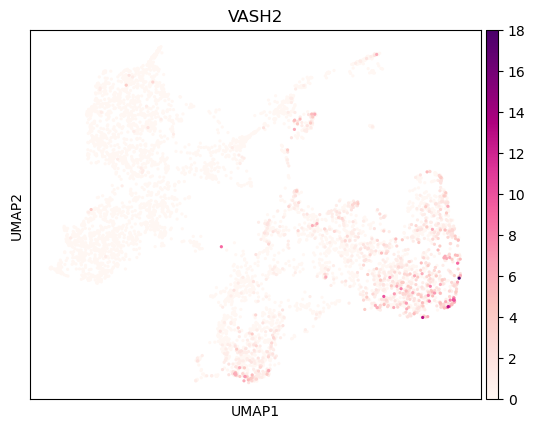

In [12]:
sc.pl.umap(adata_gex,color='VASH2',cmap="RdPu")

In [13]:
# split intlo REF and QUERY
adata_ref=adata_gex[adata_gex.obs.fine_grain=="AtrialCardiomyocytesLeft"].copy()
adata_query=adata_gex[adata_gex.obs.fine_grain=="AtrialCardiomyocytesRight"].copy()

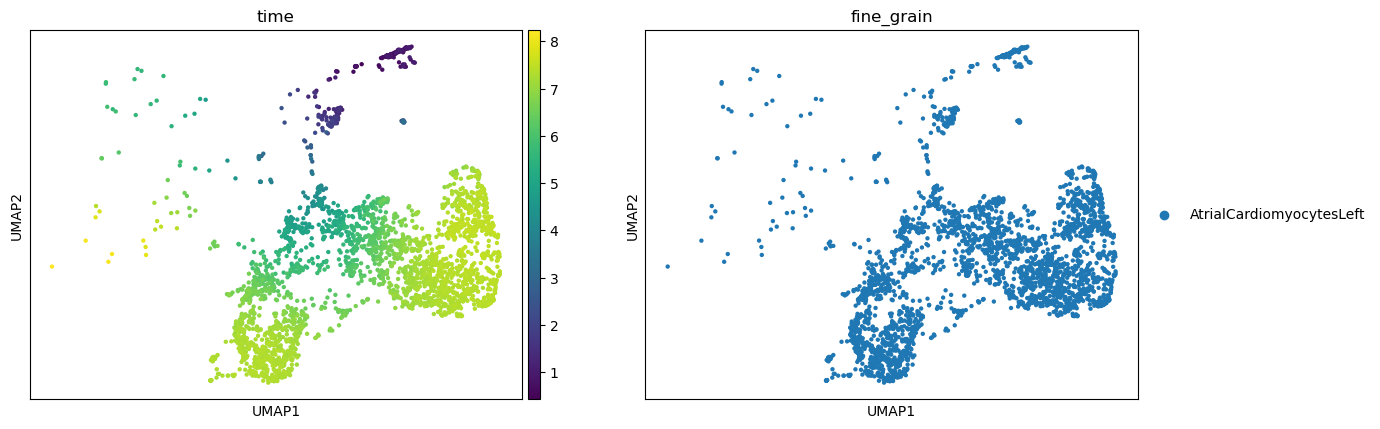

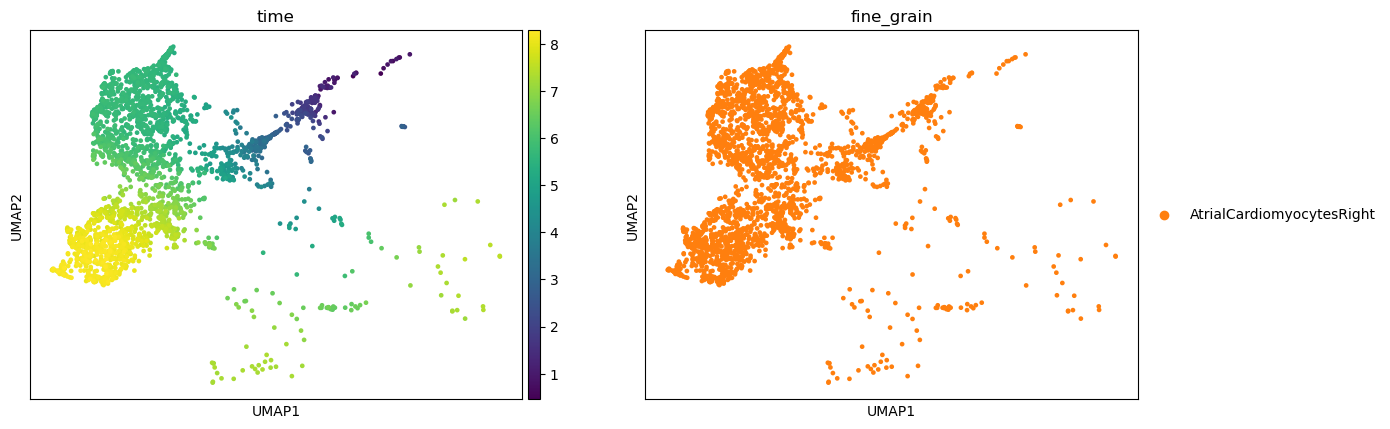

In [14]:
sc.pl.umap(adata_ref,color=["time","fine_grain"],ncols=2)
sc.pl.umap(adata_query,color=["time","fine_grain"],ncols=2)

In [15]:
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)

sc.pp.normalize_total(adata_query, target_sum=1e4)
sc.pp.log1p(adata_query)

In [16]:
print(adata_ref)
print(adata_query)

AnnData object with n_obs × n_vars = 3041 × 36601
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones', 'time'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', '

### Min max normalize the pseudotime

In [17]:
# check the current range
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

# if it does not follow [0,1] range, run below
adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

0.4222375414474298 8.245970642037001
0.45019867983228623 8.303595486512195


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


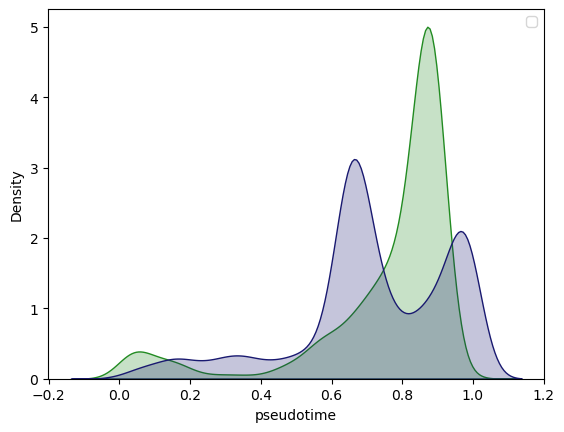

In [18]:
# Visualize the pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, color='midnightblue'); 
plt.xlabel('pseudotime'); plt.legend(); plt.show()

### Check the number of bins in the optimal binning structure using OptBinning package

In [19]:
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

12
14


OptBinning estimates 14 optimal number of splits for both reference and query pseudotime distributions. Therefore we choose the same number of interpolation points.

### Visualize the interpolation binning structure in terms of the cell type composition 

For this dataset, we use the author-given time annotations (1h,2h,4h,6h) as the cell-type annotations. 

Next we define a colormap of our choice for these annotations, and call the below function. 

In [20]:
col = np.array(sb.color_palette('colorblind'))[range(2)]
col

array([[0.00392157, 0.45098039, 0.69803922],
       [0.87058824, 0.56078431, 0.01960784]])

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


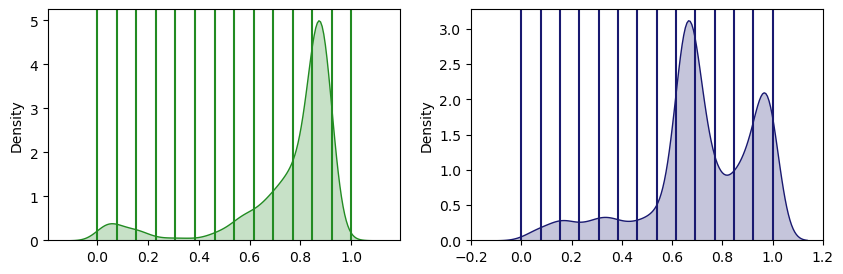

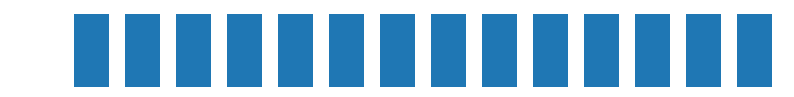

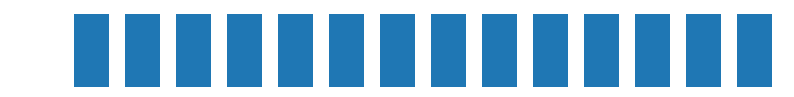

In [21]:
joint_cmap={'AtrialCardiomyocytesLeft':col[0], 'AtrialCardiomyocytesRight':col[1]}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=14, 
                                     ANNOTATION_COLNAME='fine_grain', optimal_binning=False)

### Run G2G alignment

This is done by first creating an aligner object, passing and setting all relevant parameters.
Next we align all gene pairs. (This step is parallelizing indepedenent gene-alignments to make the process time-efficient, however the computational time for an individual alignment will increase as the number of cells and/or the number of interpolation time points increase. 

In [22]:
# reads in the gene lists defined in the other notebook

import csv
import os

# Directory containing the CSV files
input_folder = "gene_lists"

# Initialize an empty dictionary to store the results
gene_lists = {}

# Iterate over each file in the directory
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        key = filename[:-4]  # Remove the '.csv' extension to get the key
        with open(os.path.join(input_folder, filename), 'r') as file:
            reader = csv.reader(file)
            # Convert each row into an item of the list (assuming one item per row)
            gene_list = [row[0] for row in reader]
            gene_lists[key] = gene_list

for k, v in gene_lists.items():
    print(f"{k}: {len(v)}")

INCREASING_genes: 1178
LEFT_DECREASING_AUCgene: 4
LEFT_INCREASING_peaks: 0
DECREASING_AUCregion: 35
RIGHT_INCREASING_genes: 61
LEFT_INCREASING_AUCgene: 0
LEFT_DECREASING_genes: 97
LEFT_genes: 277
RIGHT_AUCregion: 0
LEFT_INCREASING_genes: 72
COMMON_AUCgene: 44
RIGHT_DECREASING_peaks: 0
LEFT_INCREASING_AUCregion: 0
LEFT_peaks: 0
COMMON_genes: 1334
RIGHT_DECREASING_AUCgene: 1
RIGHT_DECREASING_genes: 57
LEFT_AUCgene: 5
LEFT_DECREASING_peaks: 0
DECREASING_genes: 5174
RIGHT_AUCgene: 2
LEFT_AUCregion: 2
RIGHT_INCREASING_AUCregion: 0
INCREASING_AUCregion: 4
DECREASING_AUCgene: 35
COMMON_peaks: 40
RIGHT_DECREASING_AUCregion: 0
INCREASING_peaks: 1571
DECREASING_peaks: 39998
RIGHT_peaks: 1
RIGHT_genes: 206
COMMON_AUCregion: 24
RIGHT_INCREASING_AUCgene: 0
LEFT_DECREASING_AUCregion: 0
INCREASING_AUCgene: 4
RIGHT_INCREASING_peaks: 0


In [23]:
# Assuming LEFT_genes, RIGHT_genes, and COMMON_genes are already defined as lists
LEFT_genes_set = set(gene_lists['LEFT_genes'])
RIGHT_genes_set = set(gene_lists['RIGHT_genes'])
COMMON_genes_set = set(gene_lists['COMMON_genes'])

# Create the union of these sets
gene_list_set = LEFT_genes_set | RIGHT_genes_set | COMMON_genes_set

In [24]:
gene_list = list(gene_list_set)
print(len(gene_list))

1546


In [25]:
# Gets a a list of all human TFs
#TFs = pd.read_csv("human_TF_list.csv", index_col=0, header=1)
#TFs = TFs.Name.unique().tolist()
#gene_list = [gene for gene in TFs if gene in adata_ref.var_names]

In [26]:
gene_list[:10]

['TEAD1',
 'KHDRBS2',
 'MYPN',
 'CTNND1',
 'AL008730.1',
 'HSPA6',
 'NPTN',
 'EXOC6B',
 'FREM2',
 'PPP4C']

In [27]:
%%time

import os
import pickle

# Path for the folder and file
folder_path = '/nfs/team205/jc48/projects/fetal/code/g2g_aligners'
file_path = os.path.join(folder_path, 'COMMON_LEFT_RIGHT_aligner.pkl')

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Check if the file already exists
if os.path.isfile(file_path):
    # Read the aligner object from the file
    print("this specific aligner already exists, reading it in...")
    with open(file_path, 'rb') as file:
        aligner = pickle.load(file)
else:
    # If the file does not exist, create and configure the aligner
    print("aligner not already made, making it...")
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE = 0.1
    aligner.state_params = [0.99, 0.1, 0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T

    # Align all pairs
    aligner.align_all_pairs()

    # Save the aligner object to the file
    with open(file_path, 'wb') as file:
        pickle.dump(aligner, file)


this specific aligner already exists, reading it in...
CPU times: user 2.83 s, sys: 706 ms, total: 3.54 s
Wall time: 3.54 s


Now we can check the aggregate (average) alignment across all genes:

Average Alignment:  IIIDMMDIDDMMMMMMMM


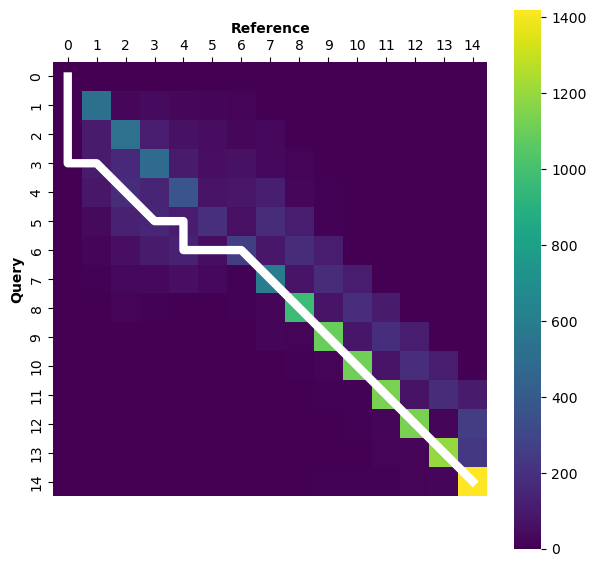

In [28]:
aligner.get_aggregate_alignment()

We can also visualize this alignment in terms of cell-type composition

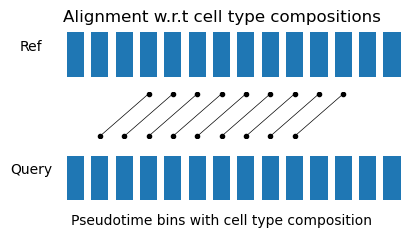

In [29]:
vs.visualize_gene_alignment("IDDDMMMMMMMMMIIIDID")#, cmap=joint_cmap)

We can also visualize an individual gene (e.g. JUNB), displaying its alignment statistics

IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Optimal alignment cost: 72.073 nits
Alignment similarity percentage: 0.0 %


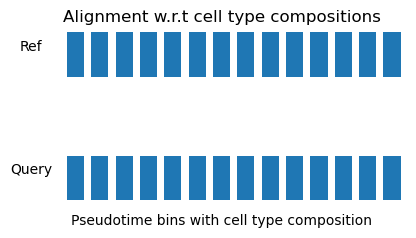

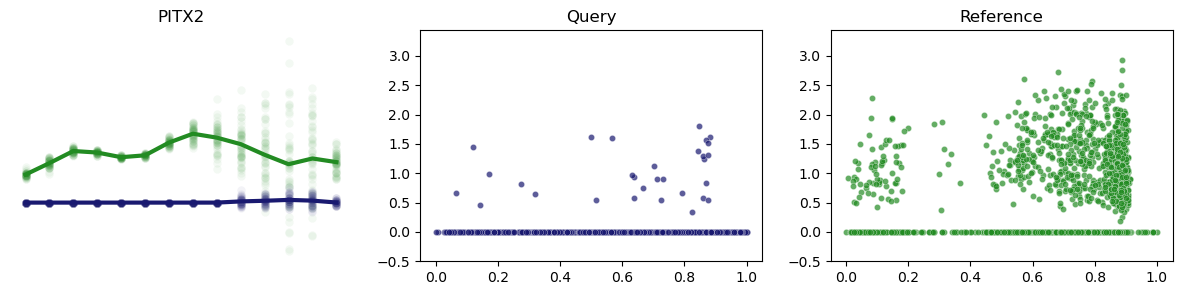

In [30]:
VisualUtils.show_gene_alignment('PITX2', aligner, vs)#, joint_cmap)

To check only the cell plots of a gene alignment (e.g. SERTAD2)

The below attributes and functions can be used to examine any gene-alignment object

### The alignment distribution across all genes 

We can use the alignment similarity percentage statistic of genes to rank genes from highly distant to highly similar

mean matched percentage: 
64.46 %


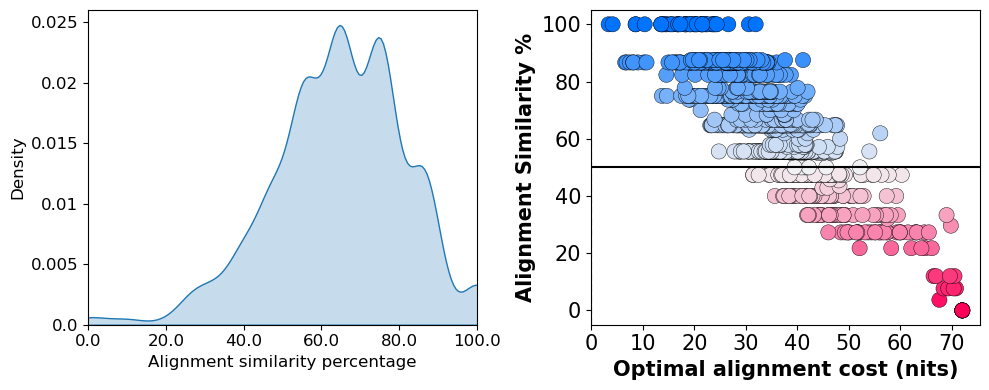

In [31]:
df = aligner.get_stat_df() 

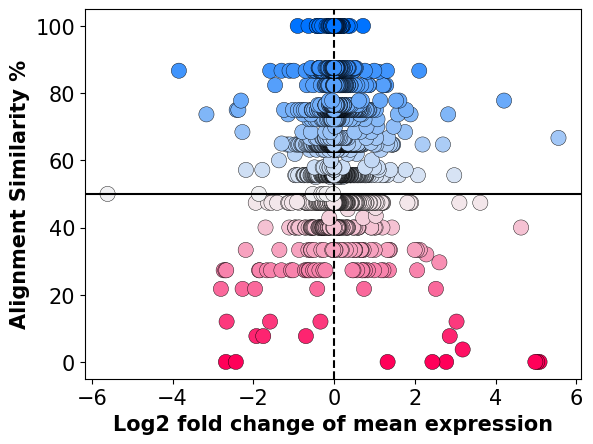

In [32]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)

In [33]:
df

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
102     PITX2                             0.0          72.073285  5.087232   
1325    VASH2                             0.0          72.073285  5.029911   
839     PANCR                             0.0          72.073285  4.983164   
1254     NAV3                             0.0          72.073285   2.77465   
1385      NTM                             0.0          72.073285 -2.679169   
...       ...                             ...                ...       ...   
615      AFF4                             1.0           8.596102 -0.021425   
54       PJA2                             1.0          24.350768  0.017249   
220     ERBIN                             1.0          17.282821  0.015276   
715   ANKRD12                             1.0           13.57806  0.007043   
1156     UBR5                             1.0          10.355713  0.002385   

      color  abs_l2fc  
102     red  5.087232  
1325    red  5.029911  
839     red  4.983164  
1254    red   2.77465  
1385    red  2.679169  
...     ...       ...  
615   green  0.021425  
54    green  0.017249  
220   green  0.015276  
715   green  0.007043  
1156  green  0.002385  

[1546 rows x 6 columns]

In [34]:
gene_list = df[(df["alignment_similarity_percentage"]<0.45)&(df["abs_l2fc"]>0)].sort_values('alignment_similarity_percentage', ascending=True).Gene.tolist()
gene_list[:10]

['PITX2',
 'VASH2',
 'PANCR',
 'NAV3',
 'NTM',
 'PCDH7',
 'ROR1',
 'DCBLD2',
 'KCNMB2-AS1',
 'ZNF385B']

In [42]:
# adjust 'alignment_similarity_percentage' so it is actuall a perecntage
df['alignment_similarity_percentage'] *= 100
df

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
102     PITX2                             0.0          72.073285  5.087232   
1325    VASH2                             0.0          72.073285  5.029911   
839     PANCR                             0.0          72.073285  4.983164   
1254     NAV3                             0.0          72.073285   2.77465   
1385      NTM                             0.0          72.073285 -2.679169   
...       ...                             ...                ...       ...   
615      AFF4                           100.0           8.596102 -0.021425   
54       PJA2                           100.0          24.350768  0.017249   
220     ERBIN                           100.0          17.282821  0.015276   
715   ANKRD12                           100.0           13.57806  0.007043   
1156     UBR5                           100.0          10.355713  0.002385   

      color  abs_l2fc trajectory       trend  
102     red  5.087232       LaCM  Unchanging  
1325    red  5.029911       LaCM  Increasing  
839     red  4.983164       LaCM  Unchanging  
1254    red   2.77465       LaCM  Unchanging  
1385    red  2.679169       RaCM  Increasing  
...     ...       ...        ...         ...  
615   green  0.021425     Common  Increasing  
54    green  0.017249     Common  Unchanging  
220   green  0.015276     Common  Unchanging  
715   green  0.007043     Common  Unchanging  
1156  green  0.002385     Common  Increasing  

[1546 rows x 8 columns]

In [43]:
LEFT_genes_set = set(gene_lists['LEFT_genes'])
RIGHT_genes_set = set(gene_lists['RIGHT_genes'])
COMMON_genes_set = set(gene_lists['COMMON_genes'])

def classify_trajectory(gene):
    if gene in LEFT_genes_set:
        return "LaCM"
    elif gene in RIGHT_genes_set:
        return "RaCM"
    else:
        return "Common"

# Add the 'trajectory' column
df['trajectory'] = df['Gene'].apply(classify_trajectory)





INCREASING_genes_set = set(gene_lists['INCREASING_genes'])
DECREASING_genes_set = set(gene_lists['DECREASING_genes'])

def classify_trend(gene):
    if gene in INCREASING_genes_set:
        return "Increasing"
    elif gene in RIGHT_genes_set:
        return "Decreasing"
    else:
        return "Unchanging"

# Add the 'trajectory' column
df['trend'] = df['Gene'].apply(classify_trend)

df

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
102     PITX2                             0.0          72.073285  5.087232   
1325    VASH2                             0.0          72.073285  5.029911   
839     PANCR                             0.0          72.073285  4.983164   
1254     NAV3                             0.0          72.073285   2.77465   
1385      NTM                             0.0          72.073285 -2.679169   
...       ...                             ...                ...       ...   
615      AFF4                           100.0           8.596102 -0.021425   
54       PJA2                           100.0          24.350768  0.017249   
220     ERBIN                           100.0          17.282821  0.015276   
715   ANKRD12                           100.0           13.57806  0.007043   
1156     UBR5                           100.0          10.355713  0.002385   

      color  abs_l2fc trajectory       trend  
102     red  5.087232       LaCM  Unchanging  
1325    red  5.029911       LaCM  Increasing  
839     red  4.983164       LaCM  Unchanging  
1254    red   2.77465       LaCM  Unchanging  
1385    red  2.679169       RaCM  Increasing  
...     ...       ...        ...         ...  
615   green  0.021425     Common  Increasing  
54    green  0.017249     Common  Unchanging  
220   green  0.015276     Common  Unchanging  
715   green  0.007043     Common  Unchanging  
1156  green  0.002385     Common  Increasing  

[1546 rows x 8 columns]

In [44]:
df[(df["opt_alignment_cost"]<50)&(df["abs_l2fc"]>4)].sort_values('alignment_similarity_percentage', ascending=True).head(20)

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
113      LRRC4C                            40.0          41.044538  4.629589   
287       BMP10                            50.0          41.927311 -5.609385   
761   LINC01608                           66.67          23.927247  5.556398   
1522      TBX18                           77.78          25.159313  4.208611   

      color  abs_l2fc trajectory       trend  
113     red  4.629589       LaCM  Increasing  
287     red  5.609385       RaCM  Increasing  
761   green  5.556398       LaCM  Unchanging  
1522  green  4.208611       LaCM  Unchanging

In [45]:
genes_of_interest = ["GATA4","PITX2","NTM"]
#genes_of_interest = ["ATP5F1B","NDUFA11","NDUFB11","NDUFAB1","ATP5MC2"]

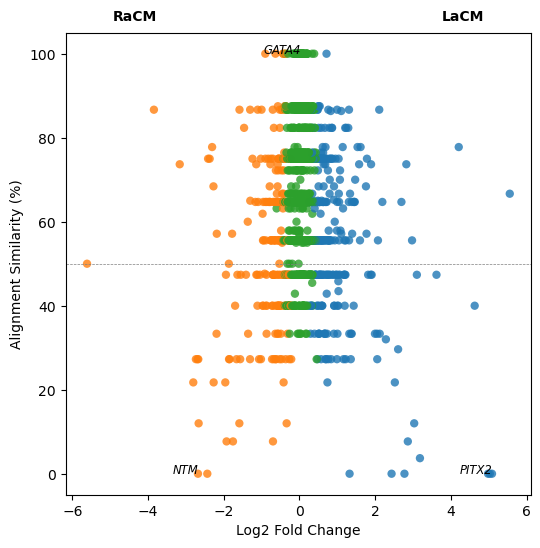

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

markers = {
    "Increasing":"^",
    "Decreasing":"v",
    "Unchanging":"o"
}

#y_axis = 'opt_alignment_cost'
y_axis = 'alignment_similarity_percentage'

sns.scatterplot(data=df, x='l2fc', y=y_axis, hue='trajectory', edgecolor="none",
                #style = 'trend', markers = markers,
                legend=False, alpha=0.8)

# Add a horizontal line at y=0.5
plt.axhline(50, color='gray', linestyle='--', linewidth = 0.5)

# Add text annotations for LaCM and RaCM
plt.text(0.1, 1.05, 'RaCM', transform=plt.gca().transAxes, ha='left', va='top', weight='semibold')
plt.text(0.9, 1.05, 'LaCM', transform=plt.gca().transAxes, ha='right', va='top', weight='semibold')

# Label specific genes
for gene in genes_of_interest:
    gene_data = df[df['Gene'] == gene]
    for _, row in gene_data.iterrows():
        plt.text(row['l2fc'], row[y_axis], gene, 
                 horizontalalignment='right', size='small', color='black', weight='regular', style='italic')

# Set labels
plt.xlabel("Log2 Fold Change")

if y_axis == "alignment_similarity_percentage":
    plt.ylabel("Alignment Similarity (%)")

if y_axis == "opt_alignment_cost":
    plt.ylabel("Alignment Cost (nits)")

# Save the plot
plt.savefig("similarity_v_logFC.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

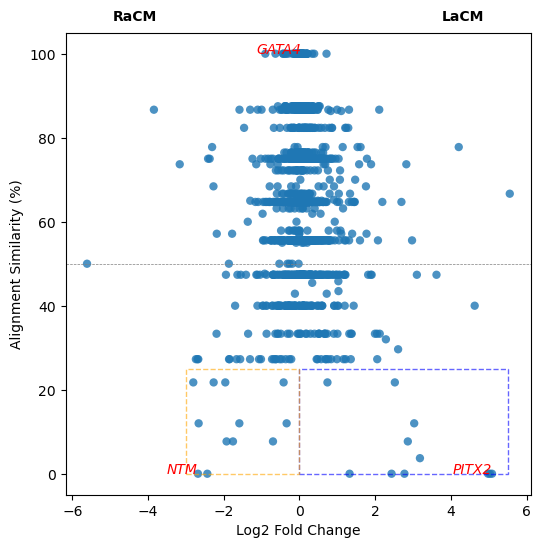

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and 'genes_of_interest' is defined

plt.figure(figsize=(6, 6))

markers = {
    "Increasing": "^",
    "Decreasing": "v",
    "Unchanging": "o"
}

y_axis = 'alignment_similarity_percentage'  # or 'opt_alignment_cost' based on your need

# Plotting the main scatterplot
sns.scatterplot(data=df, x='l2fc', y=y_axis,
                #hue='trajectory',
                edgecolor="none",
                #style='trend', markers=markers,
                legend=False, alpha=0.8)

# Add a horizontal line at y=0.5
plt.axhline(50, color='gray', linestyle='--', linewidth=0.5)

# Add text annotations for LaCM and RaCM
plt.text(0.1, 1.05, 'RaCM', transform=plt.gca().transAxes, ha='left', va='top', weight='semibold')
plt.text(0.9, 1.05, 'LaCM', transform=plt.gca().transAxes, ha='right', va='top', weight='semibold')

# Label specific genes
for gene in genes_of_interest:
    gene_data = df[df['Gene'] == gene]
    for _, row in gene_data.iterrows():
        plt.text(row['l2fc'], row[y_axis], gene, 
                 horizontalalignment='right', size='medium', color='red', weight='regular', style='italic')

# Set labels
plt.xlabel("Log2 Fold Change")
if y_axis == "alignment_similarity_percentage":
    plt.ylabel("Alignment Similarity (%)")
elif y_axis == "opt_alignment_cost":
    plt.ylabel("Alignment Cost (nits)")

# Draw rectangles to indicate boundaries of zoom-in plots
from matplotlib.patches import Rectangle

# Adjusted rectangle for blue boundary (zoom-in area)
plt.gca().add_patch(Rectangle((0, 0), 5.5, 25, linewidth=1, linestyle='--', edgecolor='blue', facecolor='none', alpha=0.6))
# Adjusted rectangle for orange boundary (zoom-in area)
plt.gca().add_patch(Rectangle((-3, 0), 3, 25, linewidth=1, linestyle='--', edgecolor='orange', facecolor='none', alpha=0.6))
plt.savefig("./figures/similarity_v_DE.pdf", bbox_inches='tight')
# Show the main plot
plt.show()

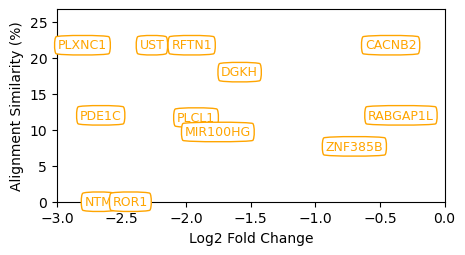

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5, 2.5))


# Filter the DataFrame for the first scatterplot
df_filtered_2 = df[(df['l2fc'] < 0) & (df['l2fc'] > -6) &
                   (df['alignment_similarity_percentage'] < 25) & 
                   (df['alignment_similarity_percentage'] >= 0)]

specific_genes = ['MIR100HG', 'PLCL1', 'DGKH']
y_adjustment = 2  # The y-axis adjustment

# Sort the DataFrame based on 'l2fc' to ensure consistent adjustment application
df_filtered_2_sorted = df_filtered_2.sort_values(by='l2fc')

# Apply y-axis adjustments for specific genes
for i, gene_name in enumerate(specific_genes):
    # Find the index of the gene in the DataFrame
    gene_idx = df_filtered_2_sorted[df_filtered_2_sorted['Gene'] == gene_name].index
    if len(gene_idx) > 0:
        # Adjust the 'alignment_similarity_percentage' by 0.05 units times the position in the specific_genes list
        df_filtered_2_sorted.loc[gene_idx, 'alignment_similarity_percentage'] += y_adjustment * (i + 1)



# Now, plot each point. Since the DataFrame is already adjusted, no need for further manipulation
for _, row in df_filtered_2_sorted.iterrows():
    plt.text(row['l2fc'], row['alignment_similarity_percentage'], row['Gene'],
             fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center', 'size': 9, 'weight': 'regular', 'color': 'orange'},
             bbox={'boxstyle': "round4", 'fc': 'white', 'ec': 'orange'})

plt.xlabel("Log2 Fold Change")
plt.ylabel("Alignment Similarity (%)")
plt.xlim(-3, 0)
plt.ylim(0, max(df_filtered_2_sorted['alignment_similarity_percentage'].max() + 5, 25))
plt.savefig("./figures/low_similarity_RaCMs.pdf", bbox_inches='tight')
plt.show()

In [186]:
df_filtered_2_sorted

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
451     PLXNC1                           21.74           52.11648 -2.803084   
1385       NTM                             0.0          72.073285 -2.679169   
808      PDE1C                            12.0          66.491642 -2.661724   
1535      ROR1                             0.0          72.073285 -2.432467   
573        UST                           21.74          58.263494 -2.265337   
263      RFTN1                           21.74          62.152862 -1.957612   
638      PLCL1                           11.69          69.328869 -1.923862   
910   MIR100HG                            9.69          70.841846 -1.755002   
1267      DGKH                            18.0          66.949475 -1.586237   
1247   ZNF385B                            7.69          70.394586 -0.698018   
1194    CACNB2                           21.74          64.122398 -0.417304   
539   RABGAP1L                            12.0          69.667116 -0.337415   

     color  abs_l2fc trajectory       trend  
451    red  2.803084       RaCM  Decreasing  
1385   red  2.679169       RaCM  Increasing  
808    red  2.661724       RaCM  Increasing  
1535   red  2.432467       RaCM  Decreasing  
573    red  2.265337       RaCM  Decreasing  
263    red  1.957612       RaCM  Decreasing  
638    red  1.923862       RaCM  Decreasing  
910    red  1.755002       RaCM  Decreasing  
1267   red  1.586237       RaCM  Decreasing  
1247   red  0.698018       RaCM  Decreasing  
1194   red  0.417304       RaCM  Decreasing  
539    red  0.337415       RaCM  Increasing

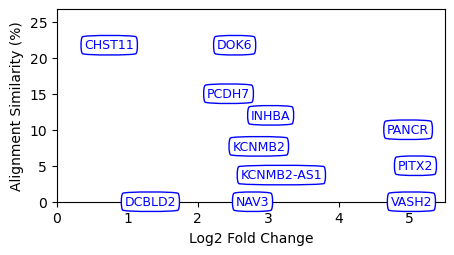

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5, 2.5))

# Filter the DataFrame for the first scatterplot
df_filtered_1 = df[(df['l2fc'] > 0) & (df['l2fc'] < 6) &
                   (df['alignment_similarity_percentage'] < 25) & 
                   (df['alignment_similarity_percentage'] >= 0)]

specific_genes = ['PITX2', 'PANCR', 'PCDH7']
y_adjustment = 5  # The y-axis adjustment

# Sort the DataFrame based on 'l2fc' to ensure consistent adjustment application
df_filtered_1_sorted = df_filtered_1.sort_values(by='l2fc')

# Apply y-axis adjustments for specific genes
for i, gene_name in enumerate(specific_genes):
    # Find the index of the gene in the DataFrame
    gene_idx = df_filtered_1_sorted[df_filtered_1_sorted['Gene'] == gene_name].index
    if len(gene_idx) > 0:
        # Adjust the 'alignment_similarity_percentage' by 0.05 units times the position in the specific_genes list
        df_filtered_1_sorted.loc[gene_idx, 'alignment_similarity_percentage'] += y_adjustment * (i + 1)



# Now, plot each point. Since the DataFrame is already adjusted, no need for further manipulation
for _, row in df_filtered_1_sorted.iterrows():
    plt.text(row['l2fc'], row['alignment_similarity_percentage'], row['Gene'],
             fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center', 'size': 9, 'weight': 'regular', 'color': 'blue'},
             bbox={'boxstyle': "round4", 'fc': 'white', 'ec': 'blue'})

plt.xlabel("Log2 Fold Change")
plt.ylabel("Alignment Similarity (%)")
plt.xlim(0, 5.5)
plt.ylim(0, max(df_filtered_1_sorted['alignment_similarity_percentage'].max() + 5, 25))
plt.savefig("./figures/low_similarity_LaCMs.pdf", bbox_inches='tight')
plt.show()


In [188]:
df_filtered_1_sorted

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
29        CHST11                           21.74           66.13557  0.740693   
524       DCBLD2                             0.0          72.073285  1.325115   
1089       PCDH7                            15.0          72.073285  2.434372   
9           DOK6                           21.74          64.882599  2.521049   
1254        NAV3                             0.0          72.073285   2.77465   
1000      KCNMB2                            7.69          68.425829  2.863564   
754        INHBA                            12.0          70.548622  3.032013   
1032  KCNMB2-AS1                             3.7          67.617187  3.183829   
839        PANCR                            10.0          72.073285  4.983164   
1325       VASH2                             0.0          72.073285  5.029911   
102        PITX2                             5.0          72.073285  5.087232   

     color  abs_l2fc trajectory       trend  
29     red  0.740693       LaCM  Unchanging  
524    red  1.325115       LaCM  Unchanging  
1089   red  2.434372       LaCM  Unchanging  
9      red  2.521049       LaCM  Unchanging  
1254   red   2.77465       LaCM  Unchanging  
1000   red  2.863564       LaCM  Increasing  
754    red  3.032013       LaCM  Unchanging  
1032   red  3.183829       LaCM  Unchanging  
839    red  4.983164       LaCM  Unchanging  
1325   red  5.029911       LaCM  Increasing  
102    red  5.087232       LaCM  Unchanging

In [54]:
query_color = 'orange'
ref_color = 'blue'

def plotTimeSeries_cmap(gene, aligner, plot_cells = False, plot_mean_trend= False):
    
        al_obj = aligner.results_map[gene]
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(gene, aligner) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(aligner.ref_mat[al_obj.gene])), np.max(np.asarray(aligner.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(aligner.ref_mat[al_obj.gene])), np.min(np.asarray(aligner.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=aligner.query_time, y=np.asarray(aligner.query_mat[al_obj.gene]), alpha=0.7, color = query_color, legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=aligner.ref_time, y=np.asarray(aligner.ref_mat[al_obj.gene]), color = ref_color, alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])

def plotTimeSeriesAlignment_cmap(gene, aligner):  
    
        al_obj = aligner.results_map[gene]
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = ref_color ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = query_color ,alpha=0.05, legend=False)#, label ='Query') 
        plot_mean_trends(al_obj)
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=1.5)

def plot_mean_trends(al_obj):
    # Plotting the mean trends for S and T with specified colors
    al_obj.S.plot_mean_trend(color=ref_color)
    al_obj.T.plot_mean_trend(color=query_color)

GATA4


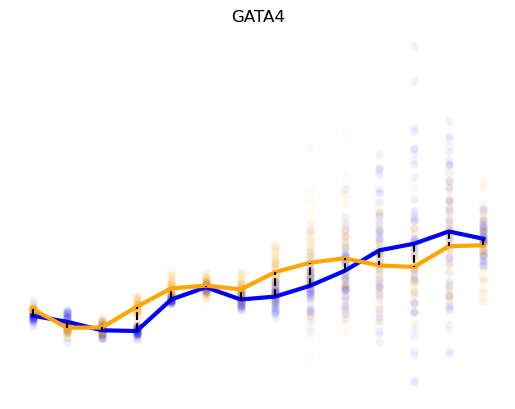

PITX2


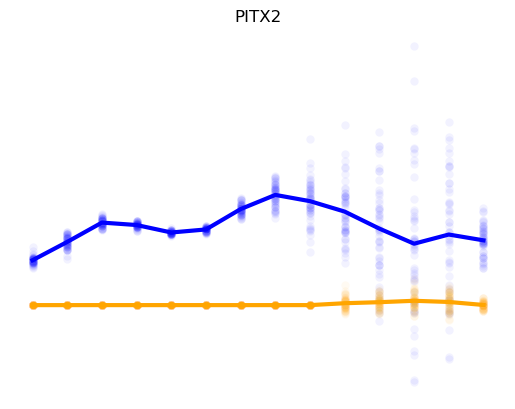

NTM


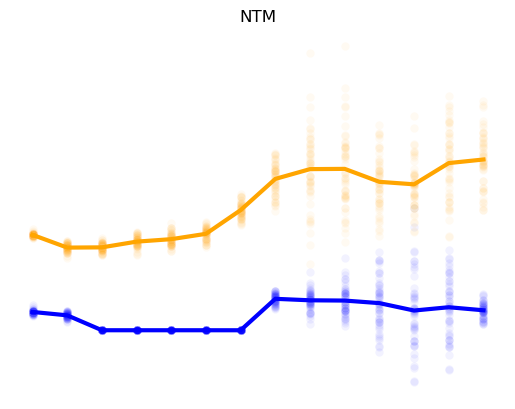

In [46]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


for gene in genes_of_interest:
    print(gene)
    # Redirect the output of the plot function to a StringIO object
    f = io.StringIO()
    with redirect_stdout(f):
        #VisualUtils.plotTimeSeries(gene, aligner, vs)
        #VisualUtils.plotTimeSeriesAlignment(gene, aligner)
        plotTimeSeriesAlignment_cmap(gene, aligner)

    
    # Now, the plot is created and can be saved
    plt.savefig(f"{gene}_time_series_alignment.png", format='png', bbox_inches='tight')
    plt.show() 

### Run gene set overrepresentation analysis over the top k mismatching genes

Let us use 30% alignment similarity (=0.3) as a threshold in this case

In [173]:
df.loc[df['Gene']=='MB',:]

Gene alignment_similarity_percentage opt_alignment_cost      l2fc color  \
173   MB                           47.37          48.201093 -0.149842   red   

     abs_l2fc trajectory       trend  
173  0.149842     Common  Increasing

In [174]:
lowSimGenes = df[list(df['alignment_similarity_percentage'] < 30)]
topSimGenes = df[list(df['alignment_similarity_percentage'] > 30)]

# COMMON | HIGH SIMILARITY | INCREASING

In [175]:
highly_similar_common_genes = topSimGenes[topSimGenes['trajectory']=="Common"]['Gene'].tolist()
INCREASING_highly_similar_common_genes = [gene for gene in highly_similar_common_genes if gene in gene_lists['INCREASING_genes']]
len(INCREASING_highly_similar_common_genes)

250

MSigDB_Hallmark_2020


Gene_set                               Term Overlap   P-value  \
0  MSigDB_Hallmark_2020                     UV Response Dn   9/144  0.000085   
1  MSigDB_Hallmark_2020                         Myogenesis  10/200  0.000220   
2  MSigDB_Hallmark_2020                    Mitotic Spindle   9/199  0.000926   
4  MSigDB_Hallmark_2020                  Androgen Response   5/100  0.008434   
3  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   8/200  0.003761   
6  MSigDB_Hallmark_2020              Fatty Acid Metabolism   6/158  0.014620   
5  MSigDB_Hallmark_2020                            Hypoxia   7/200  0.013109   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.003389            0                     0    5.426003   
1          0.004390            0                     0    4.289474   
2          0.012344            0                     0    3.844508   
4          0.067472            0                     0    4.222342   
3          0.037611            0                     0    3.367424   
6          0.083540            0                     0    3.170513   
5          0.083540            0                     0    2.919017   

   Combined Score                                              Genes  n_genes  
0       50.874284  WDR37;ZMIZ1;ATP2B4;PTPN21;LTBP1;KALRN;IGF1R;SY...        9  
1       36.134960  CAMK2B;DTNA;COL4A2;MB;CDH13;PDE4DIP;SORBS1;LAR...       10  
2       26.853265  AKAP13;NIN;ARHGEF12;DST;PCGF5;STK38L;RICTOR;AC...        9  
4       20.163715                     ZMIZ1;ACTN1;ARID5B;PTPN21;ELL2        5  
3       18.800517       COPA;COL4A2;DST;COL4A1;CALD1;SGCG;CAP2;VEGFA        8  
6       13.396679                    HADHB;AUH;MLYCD;XIST;ACO2;PPARA        6  
5       12.652356          ERO1A;WSB1;DTNA;P4HA1;LARGE1;PPFIA4;VEGFA        7

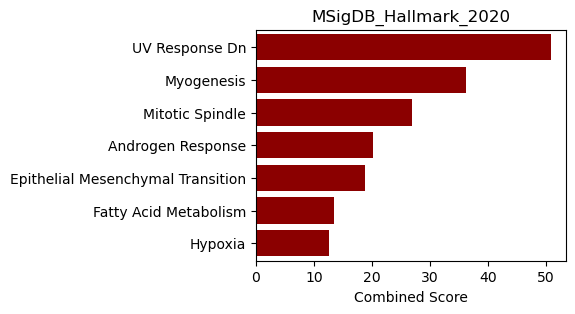

In [176]:
gsea_results=GO_plot(gene_list = INCREASING_highly_similar_common_genes, n_genes=5, display_table=True,
        #gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2023','KEGG_2021_Human'],
        gene_sets=['MSigDB_Hallmark_2020'],
                    FDR=0.1)

In [177]:
gsea_results["pct_genes_in_set"] = round((gsea_results["n_genes"] / len(INCREASING_highly_similar_common_genes)) * 100, 2)
gsea_results["neglog10"] = np.negative(np.log10(gsea_results['Adjusted P-value']))
gsea_results = gsea_results[gsea_results['Adjusted P-value']<0.05]
gsea_results

Gene_set                               Term Overlap   P-value  \
0  MSigDB_Hallmark_2020                     UV Response Dn   9/144  0.000085   
1  MSigDB_Hallmark_2020                         Myogenesis  10/200  0.000220   
2  MSigDB_Hallmark_2020                    Mitotic Spindle   9/199  0.000926   
3  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   8/200  0.003761   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.003389            0                     0    5.426003   
1          0.004390            0                     0    4.289474   
2          0.012344            0                     0    3.844508   
3          0.037611            0                     0    3.367424   

   Combined Score                                              Genes  n_genes  \
0       50.874284  WDR37;ZMIZ1;ATP2B4;PTPN21;LTBP1;KALRN;IGF1R;SY...        9   
1       36.134960  CAMK2B;DTNA;COL4A2;MB;CDH13;PDE4DIP;SORBS1;LAR...       10   
2       26.853265  AKAP13;NIN;ARHGEF12;DST;PCGF5;STK38L;RICTOR;AC...        9   
3       18.800517       COPA;COL4A2;DST;COL4A1;CALD1;SGCG;CAP2;VEGFA        8   

   pct_genes_in_set  neglog10  
0               3.6  2.469892  
1               4.0  2.357511  
2               3.6  1.908538  
3               3.2  1.424690

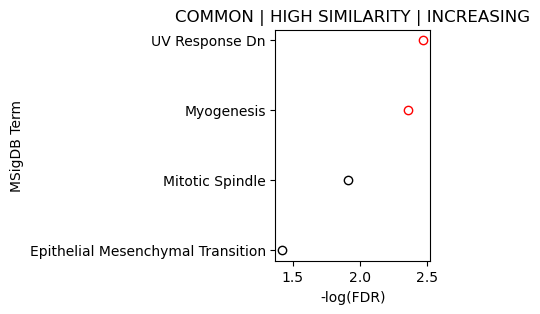

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming gsea_results is your DataFrame

# Sort the DataFrame in decreasing order of neglog10 values
gsea_results_sorted = gsea_results.sort_values(by="neglog10", ascending=True)

plt.figure(figsize=(2, 3))

# Iterate over each row in the sorted DataFrame and plot individually
for _, row in gsea_results_sorted.iterrows():
    edge_color = 'red' if row["neglog10"] > 2 else 'black'
    plt.scatter(x=row["neglog10"], y=row["Term"], edgecolor=edge_color, color='white', lw=1)

plt.title("COMMON | HIGH SIMILARITY | INCREASING")
plt.ylabel("MSigDB Term")
plt.xlabel("-log(FDR)")

# Save the figure
plt.savefig(fname="./figures/COMMON___HIGH_SIMILARITY___INCREASING.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# COMMON | HIGH SIMILARITY | DECREASING

In [179]:
highly_similar_common_genes = topSimGenes[topSimGenes['trajectory']=="Common"]['Gene'].tolist()
DECREASING_highly_similar_common_genes = [gene for gene in highly_similar_common_genes if gene in gene_lists['DECREASING_genes']]
len(DECREASING_highly_similar_common_genes)

399

MSigDB_Hallmark_2020


Gene_set                             Term Overlap  \
0   MSigDB_Hallmark_2020                   Myc Targets V1  42/200   
1   MSigDB_Hallmark_2020        Oxidative Phosphorylation  42/200   
2   MSigDB_Hallmark_2020                     Adipogenesis  17/200   
3   MSigDB_Hallmark_2020  Reactive Oxygen Species Pathway    6/49   
4   MSigDB_Hallmark_2020                      Pperoxisome   8/104   
5   MSigDB_Hallmark_2020         PI3K/AKT/mTOR  Signaling   7/105   
7   MSigDB_Hallmark_2020                Protein Secretion    6/96   
6   MSigDB_Hallmark_2020                       Glycolysis  10/200   
8   MSigDB_Hallmark_2020            Fatty Acid Metabolism   8/158   
12  MSigDB_Hallmark_2020        Unfolded Protein Response   6/113   
10  MSigDB_Hallmark_2020                 mTORC1 Signaling   9/200   
9   MSigDB_Hallmark_2020                       Myogenesis   9/200   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   8.164263e-31      1.796138e-29            0                     0   
1   8.164263e-31      1.796138e-29            0                     0   
2   5.871453e-07      8.611464e-06            0                     0   
3   4.112475e-04      4.523722e-03            0                     0   
4   1.138054e-03      1.001488e-02            0                     0   
5   5.096080e-03      3.737125e-02            0                     0   
7   1.250297e-02      6.876631e-02            0                     0   
6   7.051224e-03      4.432198e-02            0                     0   
8   1.415391e-02      6.919688e-02            0                     0   
12  2.580385e-02      8.733610e-02            0                     0   
10  1.932153e-02      7.728611e-02            0                     0   
9   1.932153e-02      7.728611e-02            0                     0   

    Odds Ratio  Combined Score  \
0    14.477290     1002.992004   
1    14.477290     1002.992004   
2     4.722141       67.753251   
3     6.944080       54.138234   
4     4.157076       28.178470   
5     3.553754       18.761273   
7     3.309754       14.502645   
6     2.626302       13.012156   
8     2.653163       11.296543   
12    2.781480       10.172516   
10    2.345147        9.255206   
9     2.345147        9.255206   

                                                Genes  n_genes  
0   EIF4A1;SLC25A3;SET;HSP90AB1;PSMD14;RPLP0;PHB;C...       42  
1   FH;SLC25A3;NDUFB8;NDUFB7;COX4I1;NDUFB3;ATP5MC2...       42  
2   COX8A;NDUFB7;GPX4;MDH2;ECH1;CHCHD10;UQCR11;UQC...       17  
3                 PDLIM1;PRDX2;NDUFA6;GPX4;PRDX6;SOD1        6  
4         FIS1;PRDX5;CNBP;ECH1;IDH2;PABPC1;YWHAH;SOD1        8  
5              ARF1;YWHAB;CFL1;CSNK2B;RAC1;PFN1;AP2M1        7  
7                    CD63;ARF1;ATP1A1;AP2M1;COPE;SOD1        6  
6   VCAN;TPI1;HSPA5;CITED2;MDH2;PGAM1;STMN1;PGAM2;...       10  
8     HSP90AA1;FH;MDH2;ECH1;RAP1GDS1;ENO3;PRDX6;YWHAH        8  
12              EIF4A2;EIF4A1;RPS14;SPCS1;HSPA5;BANF1        6  
10  MLLT11;TPI1;PSMB5;PSMD14;HSPA5;HSPE1;PPIA;GAPD...        9  
9   EIF4A2;MEF2C;TNNC1;TPM2;MYL3;PGAM2;HSPB2;TNNI1...        9

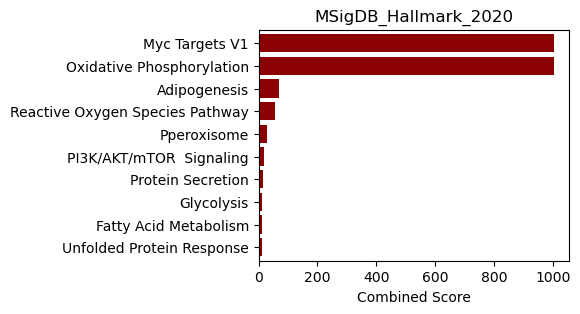

In [180]:
gsea_results=GO_plot(gene_list = DECREASING_highly_similar_common_genes, n_genes=5, display_table=True,
        #gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2023','KEGG_2021_Human'],
        gene_sets=['MSigDB_Hallmark_2020'],
                    FDR=0.1)

In [181]:
gsea_results["pct_genes_in_set"] = round((gsea_results["n_genes"] / len(DECREASING_highly_similar_common_genes)) * 100, 2)
gsea_results["neglog10"] = np.negative(np.log10(gsea_results['Adjusted P-value']))
gsea_results = gsea_results[gsea_results['Adjusted P-value']<0.05]
gsea_results

Gene_set                             Term Overlap  \
0  MSigDB_Hallmark_2020                   Myc Targets V1  42/200   
1  MSigDB_Hallmark_2020        Oxidative Phosphorylation  42/200   
2  MSigDB_Hallmark_2020                     Adipogenesis  17/200   
3  MSigDB_Hallmark_2020  Reactive Oxygen Species Pathway    6/49   
4  MSigDB_Hallmark_2020                      Pperoxisome   8/104   
5  MSigDB_Hallmark_2020         PI3K/AKT/mTOR  Signaling   7/105   
6  MSigDB_Hallmark_2020                       Glycolysis  10/200   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  8.164263e-31      1.796138e-29            0                     0   
1  8.164263e-31      1.796138e-29            0                     0   
2  5.871453e-07      8.611464e-06            0                     0   
3  4.112475e-04      4.523722e-03            0                     0   
4  1.138054e-03      1.001488e-02            0                     0   
5  5.096080e-03      3.737125e-02            0                     0   
6  7.051224e-03      4.432198e-02            0                     0   

   Odds Ratio  Combined Score  \
0   14.477290     1002.992004   
1   14.477290     1002.992004   
2    4.722141       67.753251   
3    6.944080       54.138234   
4    4.157076       28.178470   
5    3.553754       18.761273   
6    2.626302       13.012156   

                                               Genes  n_genes  \
0  EIF4A1;SLC25A3;SET;HSP90AB1;PSMD14;RPLP0;PHB;C...       42   
1  FH;SLC25A3;NDUFB8;NDUFB7;COX4I1;NDUFB3;ATP5MC2...       42   
2  COX8A;NDUFB7;GPX4;MDH2;ECH1;CHCHD10;UQCR11;UQC...       17   
3                PDLIM1;PRDX2;NDUFA6;GPX4;PRDX6;SOD1        6   
4        FIS1;PRDX5;CNBP;ECH1;IDH2;PABPC1;YWHAH;SOD1        8   
5             ARF1;YWHAB;CFL1;CSNK2B;RAC1;PFN1;AP2M1        7   
6  VCAN;TPI1;HSPA5;CITED2;MDH2;PGAM1;STMN1;PGAM2;...       10   

   pct_genes_in_set   neglog10  
0             10.53  28.745660  
1             10.53  28.745660  
2              4.26   5.064923  
3              1.50   2.344504  
4              2.01   1.999354  
5              1.75   1.427462  
6              2.51   1.353381

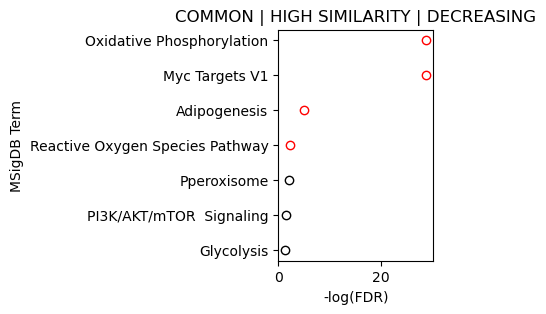

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming gsea_results is your DataFrame

# Sort the DataFrame in decreasing order of neglog10 values
gsea_results_sorted = gsea_results.sort_values(by="neglog10", ascending=True)

plt.figure(figsize=(2, 3))

# Iterate over each row in the sorted DataFrame and plot individually
for _, row in gsea_results_sorted.iterrows():
    edge_color = 'red' if row["neglog10"] > 2 else 'black'
    plt.scatter(x=row["neglog10"], y=row["Term"], edgecolor=edge_color, color='white', lw=1)

plt.title("COMMON | HIGH SIMILARITY | DECREASING")
plt.ylabel("MSigDB Term")
plt.xlabel("-log(FDR)")

# Save the figure
plt.savefig(fname="./figures/COMMON___HIGH_SIMILARITY___DECREASING.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [53]:
terms = ["Fatty Acid Metabolism","Myogenesis"]

term_genes_dict = {}

for term in terms:
    genes_series = gsea_results[gsea_results["Term"] == term]['Genes'].str.split(";")
    term_associated_genes_list = genes_series.sum()
    term_genes_dict[term] = term_associated_genes_list
term_genes_dict

{'Fatty Acid Metabolism': ['HADHB', 'AUH', 'MLYCD', 'XIST', 'ACO2', 'PPARA'],
 'Myogenesis': ['CAMK2B',
  'DTNA',
  'COL4A2',
  'MB',
  'CDH13',
  'PDE4DIP',
  'SORBS1',
  'LARGE1',
  'PPFIA4',
  'SGCG']}

Average Alignment:  IIIDDMMMDMMMMMMMM


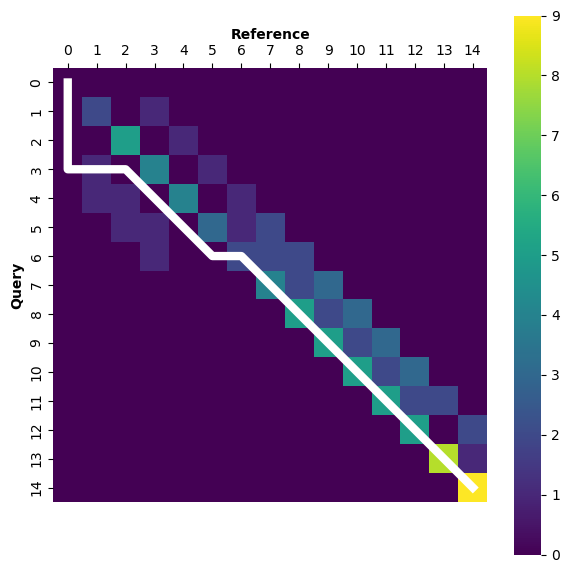

In [54]:
GENE_SUBSET = term_genes_dict["Myogenesis"]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

CAMK2B


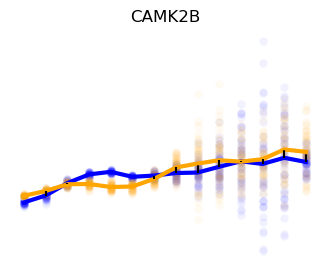

DTNA


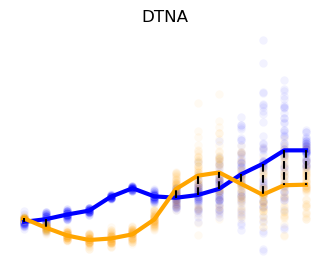

COL4A2


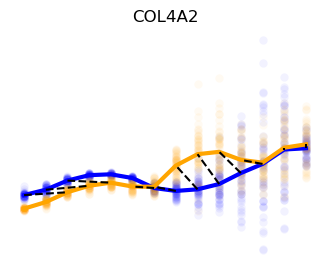

MB


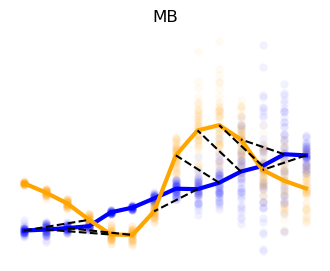

CDH13


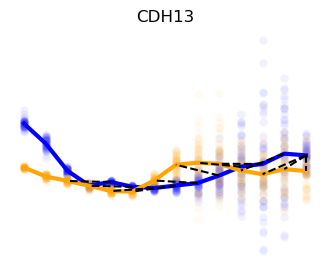

PDE4DIP


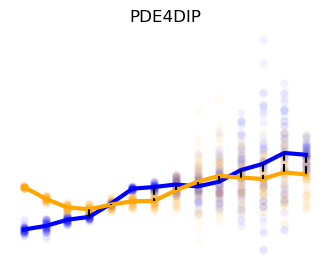

SORBS1


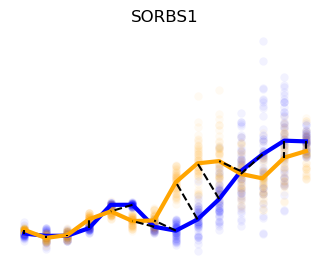

LARGE1


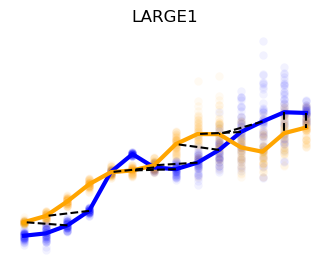

PPFIA4


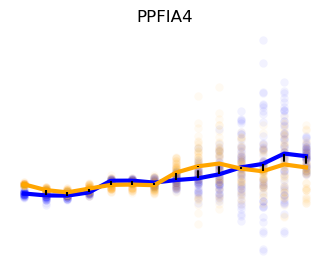

SGCG


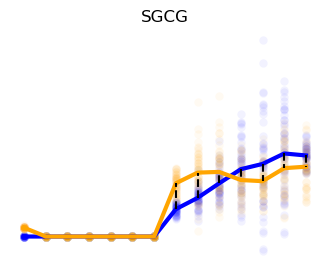

In [55]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


for gene in term_genes_dict["Myogenesis"]:
    print(gene)
    # Redirect the output of the plot function to a StringIO object
    f = io.StringIO()
    with redirect_stdout(f):
        #VisualUtils.plotTimeSeries(gene, aligner, vs)
        #VisualUtils.plotTimeSeriesAlignment(gene, aligner)
        plotTimeSeriesAlignment_cmap(gene, aligner)

    
    # Now, the plot is created and can be saved
    plt.savefig(f"{gene}_time_series_alignment.png", format='png', bbox_inches='tight')
    plt.show() 

# COMMON | HIGH SIMILALRITY | DECREASING

In [64]:
highly_similar_common_genes = topSimGenes[topSimGenes['trajectory']=="Common"]['Gene'].tolist()
DECREASING_highly_similar_common_genes = [gene for gene in highly_similar_common_genes if gene in gene_lists['DECREASING_genes']]
len(DECREASING_highly_similar_common_genes)

389

MSigDB_Hallmark_2020


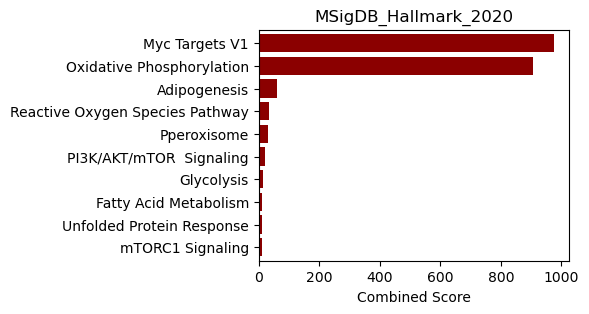

In [65]:
gsea_results=GO_plot(gene_list = DECREASING_highly_similar_common_genes, n_genes=5, display_table=False,
        #gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2023','KEGG_2021_Human'])
        gene_sets=['MSigDB_Hallmark_2020'],
                     FDR=0.1)

In [67]:
gsea_results["pct_genes_in_set"] = round((gsea_results["n_genes"] / len(DECREASING_highly_similar_common_genes)) * 100, 2)
gsea_results["neglog10"] = np.negative(np.log10(gsea_results['Adjusted P-value']))
gsea_results = gsea_results[gsea_results['Adjusted P-value']<0.2]
gsea_results

Gene_set                             Term Overlap  \
0   MSigDB_Hallmark_2020                   Myc Targets V1  41/200   
1   MSigDB_Hallmark_2020        Oxidative Phosphorylation  40/200   
2   MSigDB_Hallmark_2020                     Adipogenesis  16/200   
4   MSigDB_Hallmark_2020  Reactive Oxygen Species Pathway    5/49   
3   MSigDB_Hallmark_2020                      Pperoxisome   8/104   
5   MSigDB_Hallmark_2020         PI3K/AKT/mTOR  Signaling   7/105   
6   MSigDB_Hallmark_2020                       Glycolysis  10/200   
7   MSigDB_Hallmark_2020            Fatty Acid Metabolism   8/158   
10  MSigDB_Hallmark_2020        Unfolded Protein Response   6/113   
9   MSigDB_Hallmark_2020                 mTORC1 Signaling   9/200   
8   MSigDB_Hallmark_2020                       Myogenesis   9/200   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   4.242035e-30      1.866495e-28            0                     0   
1   6.074530e-29      1.336397e-27            0                     0   
2   2.016275e-06      2.957203e-05            0                     0   
4   2.562145e-03      2.254688e-02            0                     0   
3   9.674442e-04      1.064189e-02            0                     0   
5   4.445008e-03      3.259672e-02            0                     0   
6   5.938783e-03      3.732949e-02            0                     0   
7   1.230960e-02      6.770278e-02            0                     0   
10  2.314786e-02      8.751097e-02            0                     0   
9   1.668210e-02      7.340123e-02            0                     0   
8   1.668210e-02      7.340123e-02            0                     0   

    Odds Ratio  Combined Score  \
0    14.413576      974.826334   
1    13.933381      905.263794   
2     4.528966       59.394033   
4     5.790424       34.550940   
3     4.268373       29.626147   
5     3.648654       19.761012   
6     2.696987       13.825430   
7     2.724199       11.979330   
10    2.855567       10.753647   
9     2.408101        9.857368   
8     2.408101        9.857368   

                                                Genes  n_genes  \
0   EIF4A1;SLC25A3;SET;HSP90AB1;PSMD14;RPLP0;PHB;C...       41   
1   FH;SLC25A3;NDUFB8;NDUFB7;COX4I1;NDUFB3;ATP5MC3...       40   
2   COX8A;NDUFB7;GPX4;MDH2;ECH1;CHCHD10;UQCR11;UQC...       16   
4                        PRDX2;NDUFA6;GPX4;PRDX6;SOD1        5   
3         FIS1;PRDX5;CNBP;ECH1;IDH2;PABPC1;YWHAH;SOD1        8   
5              ARF1;YWHAB;CFL1;CSNK2B;RAC1;PFN1;AP2M1        7   
6   VCAN;TPI1;HSPA5;CITED2;MDH2;PGAM1;STMN1;PGAM2;...       10   
7     HSP90AA1;FH;MDH2;ECH1;RAP1GDS1;ENO3;PRDX6;YWHAH        8   
10              EIF4A2;EIF4A1;RPS14;SPCS1;HSPA5;BANF1        6   
9   MLLT11;TPI1;PSMB5;PSMD14;HSPA5;HSPE1;PPIA;GAPD...        9   
8   EIF4A2;MEF2C;TNNC1;TPM2;MYL3;PGAM2;HSPB2;TNNI1...        9   

    pct_genes_in_set   neglog10  
0              10.54  27.728973  
1              10.28  26.874065  
2               4.11   4.529119  
4               1.29   1.646914  
3               2.06   1.972981  
5               1.80   1.486826  
6               2.57   1.427948  
7               2.06   1.169393  
10              1.54   1.057938  
9               2.31   1.134297  
8               2.31   1.134297

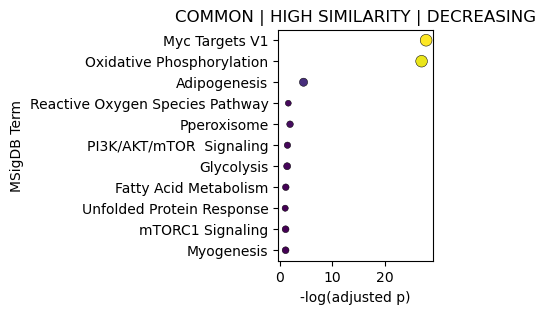

In [68]:
plt.figure(figsize=(2,3))
sb.scatterplot(data = gsea_results, x = "neglog10", y = "Term", hue = "neglog10", legend = False, palette = "viridis", size = "pct_genes_in_set", edgecolor='black')
plt.title("COMMON | HIGH SIMILARITY | DECREASING")
plt.ylabel("MSigDB Term")
plt.xlabel("-log(adjusted p)")
plt.savefig(fname="./figures/COMMON___HIGH SIMILARITY___DECREASING.pdf", format='pdf', bbox_inches='tight')
plt.show()

# LEFT | LOW SIMILALRITY | INCREASING

In [144]:
lowly_similar_left_genes = lowSimGenes[lowSimGenes['trajectory']=="RaCM"]['Gene'].tolist()
INCREASING_lowly_similar_left_genes = [gene for gene in lowly_similar_left_genes if gene in gene_lists['INCREASING_genes']]
len(INCREASING_lowly_similar_left_genes)

24

MSigDB_Hallmark_2020


Gene_set                               Term Overlap   P-value  \
0  MSigDB_Hallmark_2020                    Apical Junction   3/200  0.001708   
3  MSigDB_Hallmark_2020                 Hedgehog Signaling    1/36  0.042341   
1  MSigDB_Hallmark_2020                  KRAS Signaling Up   2/200  0.023769   
2  MSigDB_Hallmark_2020                            Hypoxia   2/200  0.023769   
4  MSigDB_Hallmark_2020                     UV Response Dn   1/144  0.159304   
5  MSigDB_Hallmark_2020                    Mitotic Spindle   1/199  0.213478   
6  MSigDB_Hallmark_2020               IL-2/STAT5 Signaling   1/199  0.213478   
7  MSigDB_Hallmark_2020                         Myogenesis   1/200  0.214431   
8  MSigDB_Hallmark_2020            Estrogen Response Early   1/200  0.214431   
9  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   1/200  0.214431   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.017077            0                     0   14.343002   
3          0.105853            0                     0   24.771429   
1          0.079230            0                     0    9.080808   
2          0.079230            0                     0    9.080808   
4          0.214431            0                     0    6.030100   
5          0.214431            0                     0    4.342995   
6          0.214431            0                     0    4.342995   
7          0.214431            0                     0    4.320953   
8          0.214431            0                     0    4.320953   
9          0.214431            0                     0    4.320953   

   Combined Score            Genes  n_genes  
0       91.402614  CDH4;MYH9;ITGA9        3  
3       78.327194             MYH9        1  
1       33.956555  RABGAP1L;GPRC5B        2  
2       33.956555      NEDD4L;MYH9        2  
4       11.076950             GRK5        1  
5        6.706552             MYH9        1  
6        6.706552         RABGAP1L        1  
7        6.653261             MYH9        1  
8        6.653261            THSD4        1  
9        6.653261              NTM        1

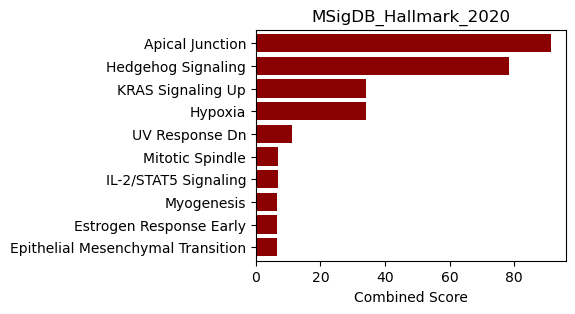

GO_Biological_Process_2023


Gene_set  \
10  GO_Biological_Process_2023   
11  GO_Biological_Process_2023   
21  GO_Biological_Process_2023   
20  GO_Biological_Process_2023   
22  GO_Biological_Process_2023   
12  GO_Biological_Process_2023   
23  GO_Biological_Process_2023   
25  GO_Biological_Process_2023   
24  GO_Biological_Process_2023   
14  GO_Biological_Process_2023   
26  GO_Biological_Process_2023   
27  GO_Biological_Process_2023   
15  GO_Biological_Process_2023   
29  GO_Biological_Process_2023   
30  GO_Biological_Process_2023   
16  GO_Biological_Process_2023   
32  GO_Biological_Process_2023   
33  GO_Biological_Process_2023   
31  GO_Biological_Process_2023   
17  GO_Biological_Process_2023   
34  GO_Biological_Process_2023   
18  GO_Biological_Process_2023   
35  GO_Biological_Process_2023   
36  GO_Biological_Process_2023   
37  GO_Biological_Process_2023   
41  GO_Biological_Process_2023   
40  GO_Biological_Process_2023   
42  GO_Biological_Process_2023   
44  GO_Biological_Process_2023   
43  GO_Biological_Process_2023   

                                                 Term Overlap   P-value  \
10  Negative Regulation Of Sodium Ion Transmembran...     2/9  0.000049   
11  Negative Regulation Of Sodium Ion Transmembran...    2/10  0.000062   
21  Regulation Of Plasma Membrane Repair (GO:1905684)     1/5  0.005986   
20  Regulation Of Basement Membrane Organization (...     1/5  0.005986   
22  Regulation Of Myosin-Light-Chain-Phosphatase A...     1/6  0.007179   
12  Negative Regulation Of Ion Transmembrane Trans...    2/24  0.000375   
23  Positive Regulation Of Macrophage Cytokine Pro...     1/8  0.009561   
25  Negative Regulation Of Protein Localization To...     1/9  0.010750   
24  Negative Regulation Of Potassium Ion Transmemb...     1/9  0.010750   
14  Regulation Of Dendrite Morphogenesis (GO:0048814)    2/31  0.000628   
26              Monocyte Differentiation (GO:0030224)    1/10  0.011938   
27        Basement Membrane Organization (GO:0071711)    1/10  0.011938   
15     Regulation Of Cellular Senescence (GO:2000772)    2/35  0.000801   
29  Negative Regulation Of Platelet-Derived Growth...    1/11  0.013124   
30  Negative Regulation Of Potassium Ion Transmemb...    1/11  0.013124   
16  Regulation Of Sodium Ion Transmembrane Transpo...    2/37  0.000896   
32  Negative Regulation Of Potassium Ion Transport...    1/12  0.014309   
33  Regulation Of Platelet-Derived Growth Factor R...    1/12  0.014309   
31  Positive Regulation Of Integrin-Mediated Signa...    1/12  0.014309   
17    Regulation Of Dendrite Development (GO:0050773)    2/41  0.001100   
34  Regulation Of Macrophage Cytokine Production (...    1/13  0.015493   
18  Regulation Of Cellular Metabolic Process (GO:0...    2/45  0.001324   
35  Negative Regulation Of Smooth Muscle Cell Migr...    1/14  0.016675   
36  Positive Regulation Of Muscle Cell Differentia...    1/15  0.017856   
37  Negative Regulation Of Cation Transmembrane Tr...    1/15  0.017856   
41  Positive Regulation Of Myeloid Leukocyte Cytok...    1/16  0.019035   
40  Regulation Of Protein Kinase C Signaling (GO:0...    1/16  0.019035   
42  Ventricular Cardiac Muscle Cell Action Potenti...    1/17  0.020213   
44      Embryonic Heart Tube Development (GO:0035050)    1/17  0.020213   
43  Positive Regulation Of Dendrite Extension (GO:...    1/17  0.020213   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
10          0.005988            0                     0  259.337662   
11          0.005988            0                     0  226.909091   
21          0.096776            0                     0  217.086957   
20          0.096776            0                     0  217.086957   
22          0.107136            0                     0  173.660870   
12          0.022264            0                     0   82.454545   
23          0.108527            0                     0  124.031056   
25          0.108527            0                     0  108.521739   
24

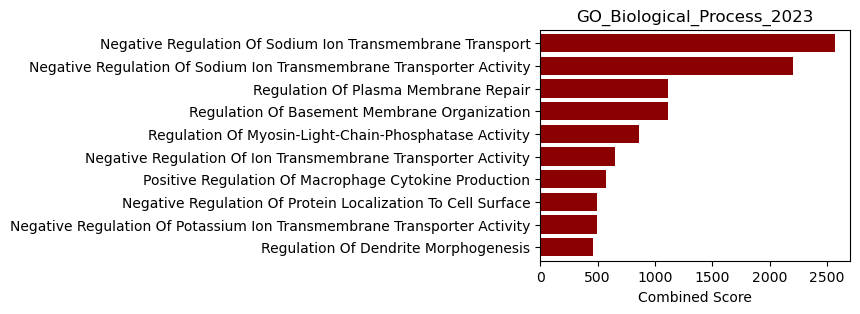

KEGG_2021_Human


Gene_set                                             Term Overlap  \
204  KEGG_2021_Human                               Morphine addiction    2/91   
209  KEGG_2021_Human        Aldosterone-regulated sodium reabsorption    1/37   
205  KEGG_2021_Human                          Cell adhesion molecules   2/148   
206  KEGG_2021_Human                                   Tight junction   2/169   
210  KEGG_2021_Human                                  Renin secretion    1/69   
207  KEGG_2021_Human                 Regulation of actin cytoskeleton   2/218   
211  KEGG_2021_Human  Arrhythmogenic right ventricular cardiomyopathy    1/77   
208  KEGG_2021_Human                                      Endocytosis   2/252   
212  KEGG_2021_Human                               Taste transduction    1/86   
213  KEGG_2021_Human                         ECM-receptor interaction    1/88   
214  KEGG_2021_Human                      Hypertrophic cardiomyopathy    1/90   
215  KEGG_2021_Human                       TGF-beta signaling pathway    1/94   
216  KEGG_2021_Human                           Dilated cardiomyopathy    1/96   
217  KEGG_2021_Human                                Purine metabolism   1/129   
218  KEGG_2021_Human               Vascular smooth muscle contraction   1/133   
219  KEGG_2021_Human                   Ubiquitin mediated proteolysis   1/140   
220  KEGG_2021_Human                      Chemokine signaling pathway   1/192   
221  KEGG_2021_Human            Pathogenic Escherichia coli infection   1/197   
222  KEGG_2021_Human                                   Focal adhesion   1/201   
223  KEGG_2021_Human                        Calcium signaling pathway   1/240   
224  KEGG_2021_Human                   Human papillomavirus infection   1/331   
225  KEGG_2021_Human                       PI3K-Akt signaling pathway   1/354   
226  KEGG_2021_Human                           Olfactory transduction   1/440   

      P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
204  0.005295          0.121783            0                     0   
209  0.043492          0.166721            0                     0   
205  0.013493          0.132955            0                     0   
206  0.017342          0.132955            0                     0   
210  0.079640          0.193055            0                     0   
207  0.027885          0.160340            0                     0   
211  0.088471          0.193055            0                     0   
208  0.036379          0.166721            0                     0   
212  0.098308          0.193055            0                     0   
213  0.100480          0.193055            0                     0   
214  0.102647          0.193055            0                     0   
215  0.106966          0.193055            0                     0   
216  0.109118          0.193055            0                     0   
217  0.143919          0.223139            0                     0   
218  0.148048          0.223139            0                     0   
219  0.155227          0.223139            0                     0   
220  0.206773          0.260727            0                     0   
221  0.211568          0.260727            0                     0   
222  0.215383          0.260727            0                     0   
223  0.251668          0.289419            0                     0   
224  0.330186          0.361632            0                     0   
225  0.348744          0.364596            0                     0   
226  0.413864          0.413864            0                     0   

     Odds Ratio  Combined Score        Genes  n_genes  
204   20.313585      106.463664   PDE1C;GRK5        2  
209   24.082126       75.501567       NEDD4L        1  
205   12.347447       53.162853   CDH4;ITGA9        2  
206   10.783342       43.722435  NEDD4L;MYH9        2  
210   12.728900       32.207117        PDE1C        1  
207    8.316498       29.770201   MYH9;ITGA9      

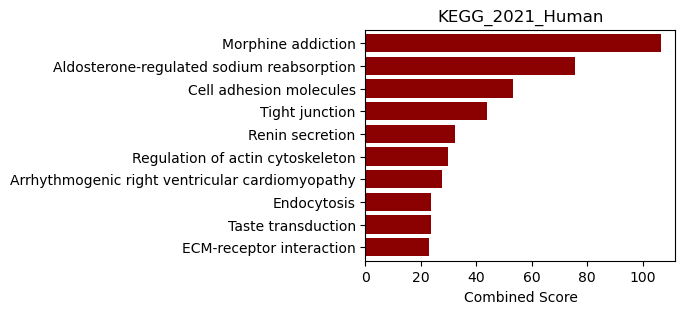

In [146]:
gsea_results=GO_plot(gene_list = INCREASING_lowly_similar_left_genes, n_genes=1, display_table=True,
        gene_sets=['MSigDB_Hallmark_2020','GO_Biological_Process_2023','KEGG_2021_Human'])
        #gene_sets=['MSigDB_Hallmark_2020'],
                     #FDR=0.1)

In [63]:
gsea_results["pct_genes_in_set"] = round((gsea_results["n_genes"] / len(INCREASING_highly_similar_common_genes)) * 100, 2)
gsea_results["neglog10"] = np.negative(np.log10(gsea_results['Adjusted P-value']))
gsea_results = gsea_results[gsea_results['Adjusted P-value']<0.2]
gsea_results

Gene_set                             Term Overlap  \
0   MSigDB_Hallmark_2020                   Myc Targets V1  41/200   
1   MSigDB_Hallmark_2020        Oxidative Phosphorylation  40/200   
2   MSigDB_Hallmark_2020                     Adipogenesis  16/200   
4   MSigDB_Hallmark_2020  Reactive Oxygen Species Pathway    5/49   
3   MSigDB_Hallmark_2020                      Pperoxisome   8/104   
5   MSigDB_Hallmark_2020         PI3K/AKT/mTOR  Signaling   7/105   
6   MSigDB_Hallmark_2020                       Glycolysis  10/200   
7   MSigDB_Hallmark_2020            Fatty Acid Metabolism   8/158   
10  MSigDB_Hallmark_2020        Unfolded Protein Response   6/113   
9   MSigDB_Hallmark_2020                 mTORC1 Signaling   9/200   
8   MSigDB_Hallmark_2020                       Myogenesis   9/200   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   4.242035e-30      1.866495e-28            0                     0   
1   6.074530e-29      1.336397e-27            0                     0   
2   2.016275e-06      2.957203e-05            0                     0   
4   2.562145e-03      2.254688e-02            0                     0   
3   9.674442e-04      1.064189e-02            0                     0   
5   4.445008e-03      3.259672e-02            0                     0   
6   5.938783e-03      3.732949e-02            0                     0   
7   1.230960e-02      6.770278e-02            0                     0   
10  2.314786e-02      8.751097e-02            0                     0   
9   1.668210e-02      7.340123e-02            0                     0   
8   1.668210e-02      7.340123e-02            0                     0   

    Odds Ratio  Combined Score  \
0    14.413576      974.826334   
1    13.933381      905.263794   
2     4.528966       59.394033   
4     5.790424       34.550940   
3     4.268373       29.626147   
5     3.648654       19.761012   
6     2.696987       13.825430   
7     2.724199       11.979330   
10    2.855567       10.753647   
9     2.408101        9.857368   
8     2.408101        9.857368   

                                                Genes  n_genes  \
0   EIF4A1;SLC25A3;SET;HSP90AB1;PSMD14;RPLP0;PHB;C...       41   
1   FH;SLC25A3;NDUFB8;NDUFB7;COX4I1;NDUFB3;ATP5MC3...       40   
2   COX8A;NDUFB7;GPX4;MDH2;ECH1;CHCHD10;UQCR11;UQC...       16   
4                        PRDX2;NDUFA6;GPX4;PRDX6;SOD1        5   
3         FIS1;PRDX5;CNBP;ECH1;IDH2;PABPC1;YWHAH;SOD1        8   
5              ARF1;YWHAB;CFL1;CSNK2B;RAC1;PFN1;AP2M1        7   
6   VCAN;TPI1;HSPA5;CITED2;MDH2;PGAM1;STMN1;PGAM2;...       10   
7     HSP90AA1;FH;MDH2;ECH1;RAP1GDS1;ENO3;PRDX6;YWHAH        8   
10              EIF4A2;EIF4A1;RPS14;SPCS1;HSPA5;BANF1        6   
9   MLLT11;TPI1;PSMB5;PSMD14;HSPA5;HSPE1;PPIA;GAPD...        9   
8   EIF4A2;MEF2C;TNNC1;TPM2;MYL3;PGAM2;HSPB2;TNNI1...        9   

    pct_genes_in_set   neglog10  
0              17.08  27.728973  
1              16.67  26.874065  
2               6.67   4.529119  
4               2.08   1.646914  
3               3.33   1.972981  
5               2.92   1.486826  
6               4.17   1.427948  
7               3.33   1.169393  
10              2.50   1.057938  
9               3.75   1.134297  
8               3.75   1.134297

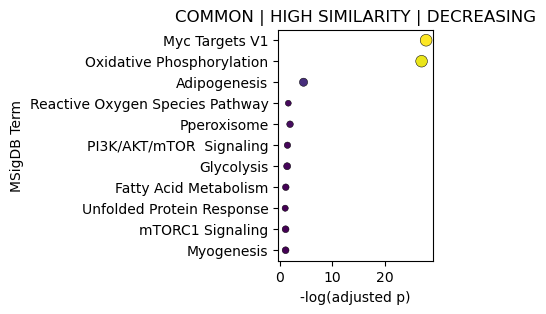

In [117]:
plt.figure(figsize=(2,3))
sb.scatterplot(data = gsea_results, x = "neglog10", y = "Term", hue = "neglog10", legend = False, palette = "viridis", size = "pct_genes_in_set", edgecolor='black')
plt.title("COMMON | HIGH SIMILARITY | DECREASING")
plt.ylabel("MSigDB Term")
plt.xlabel("-log(adjusted p)")
plt.savefig(fname="./figures/COMMON___HIGH SIMILARITY___DECREASING.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

# Assuming gsea_results is your DataFrame and it's already loaded.

# Create the figure.
plt.figure(figsize=(2, 3))

# Unique terms for plotting on y-axis.
terms = gsea_results['Term'].unique()

# Mapping terms to y-values.
term_to_y = {term: i for i, term in enumerate(terms)}

# Plot each point individually.
for _, row in gsea_results.iterrows():
    edge_color = 'red' if row['neglog10'] > 2 else 'black'
    plt.scatter(x=row['neglog10'], y=term_to_y[row['Term']], s=row['pct_genes_in_set']*10,  # Adjust size as needed
                color=sb.color_palette("viridis", as_cmap=True)(row['neglog10']), edgecolor=edge_color)

# Set the y-ticks to the term names.
plt.yticks(ticks=list(term_to_y.values()), labels=list(term_to_y.keys()))

# Set title and labels.
plt.title("COMMON | HIGH SIMILARITY | DECREASING")
plt.ylabel("MSigDB Term")
plt.xlabel("-log(adjusted p)")

# Remove the legend created by seaborn
plt.legend([],[], frameon=False)

# Save and show the plot.
plt.savefig(fname="./figures/COMMON___HIGH SIMILARITY___DECREASING.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [118]:
terms = ["Fatty Acid Metabolism","Myogenesis", "Oxidative Phosphorylation"]

term_genes_dict = {}

for term in terms:
    genes_series = gsea_results[gsea_results["Term"] == term]['Genes'].str.split(";")
    term_associated_genes_list = genes_series.sum()
    term_genes_dict[term] = term_associated_genes_list
term_genes_dict

{'Fatty Acid Metabolism': ['HSP90AA1',
  'FH',
  'MDH2',
  'ECH1',
  'RAP1GDS1',
  'ENO3',
  'PRDX6',
  'YWHAH'],
 'Myogenesis': ['EIF4A2',
  'MEF2C',
  'TNNC1',
  'TPM2',
  'MYL3',
  'PGAM2',
  'HSPB2',
  'TNNI1',
  'ENO3'],
 'Oxidative Phosphorylation': ['FH',
  'SLC25A3',
  'NDUFB8',
  'NDUFB7',
  'COX4I1',
  'NDUFB3',
  'ATP5MC3',
  'UQCR11',
  'UQCR10',
  'ETFB',
  'MRPL34',
  'COX6A1',
  'COX5A',
  'PRDX3',
  'LDHB',
  'ATP5F1B',
  'UQCRFS1',
  'POLR2F',
  'CYC1',
  'ATP5MF',
  'COX8A',
  'TIMM8B',
  'ATP5PF',
  'ATP5PD',
  'NDUFA6',
  'GPX4',
  'ATP5PB',
  'MDH2',
  'ECH1',
  'IDH2',
  'ATP5F1D',
  'ATP5F1E',
  'OXA1L',
  'NDUFS6',
  'ATP5PO',
  'CYCS',
  'SLC25A5',
  'ATP6V0C',
  'SLC25A11',
  'SLC25A6']}

Average Alignment:  IIDMMMMIDDMMMMMMM


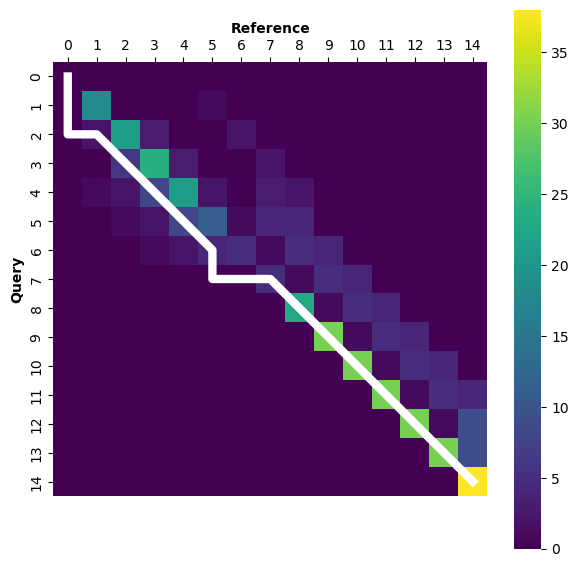

In [119]:
GENE_SUBSET = term_genes_dict["Oxidative Phosphorylation"]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

FH


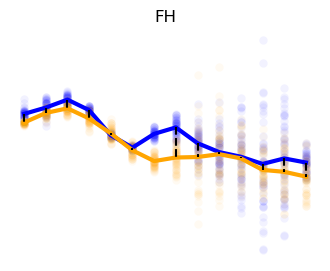

SLC25A3


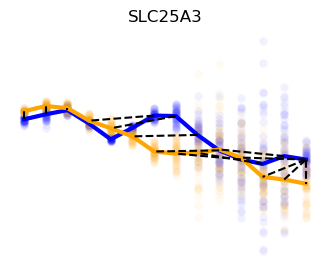

NDUFB8


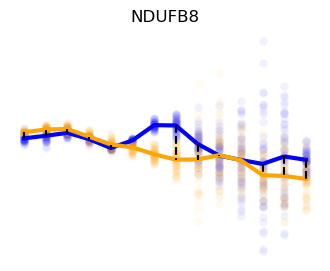

NDUFB7


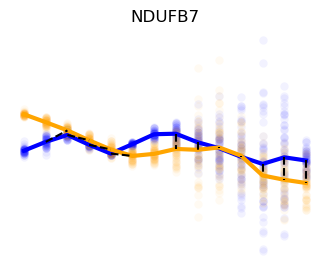

COX4I1


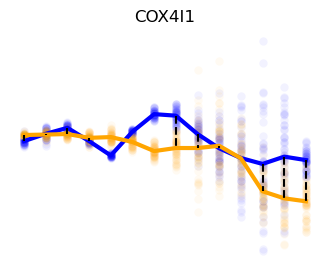

NDUFB3


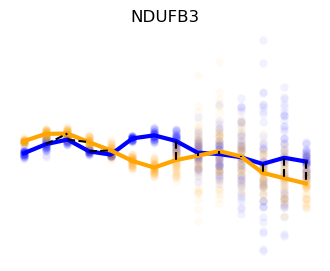

ATP5MC3


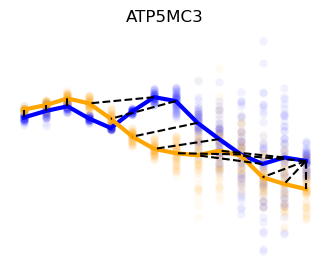

UQCR11


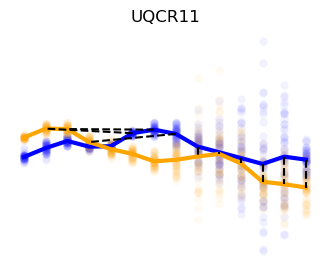

UQCR10


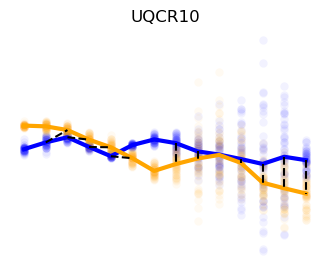

ETFB


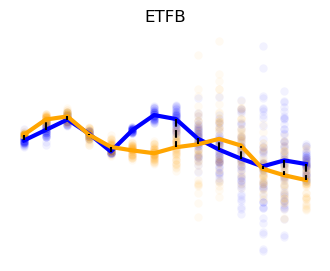

MRPL34


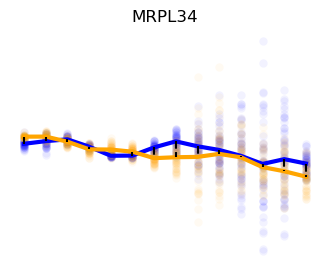

COX6A1


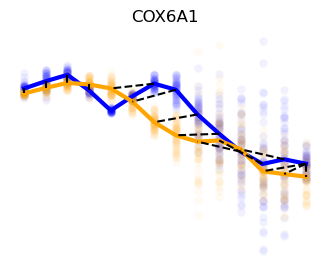

COX5A


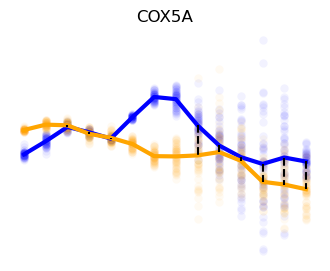

PRDX3


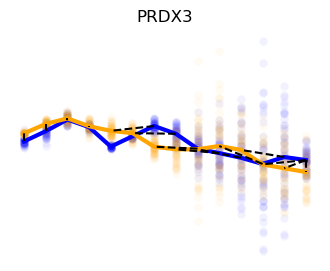

LDHB


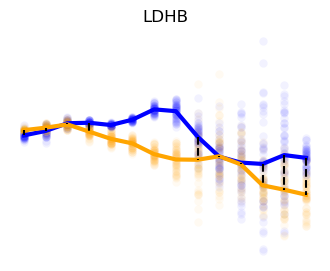

ATP5F1B


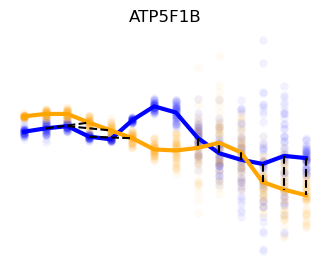

UQCRFS1


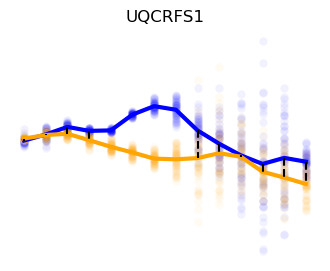

POLR2F


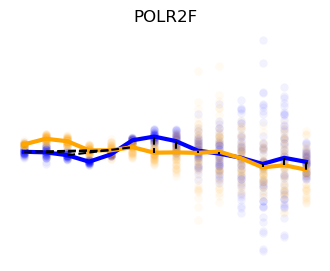

CYC1


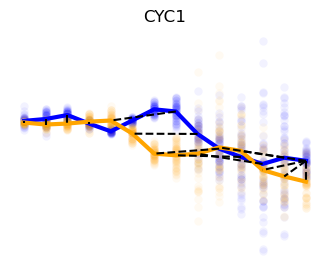

ATP5MF


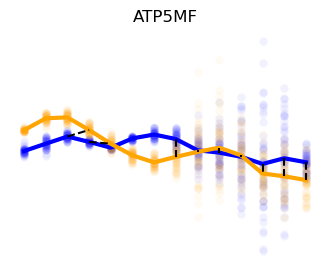

COX8A


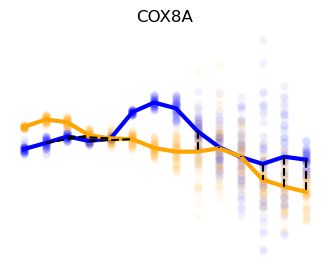

TIMM8B


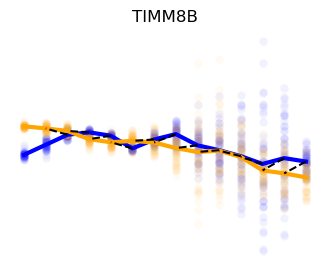

ATP5PF


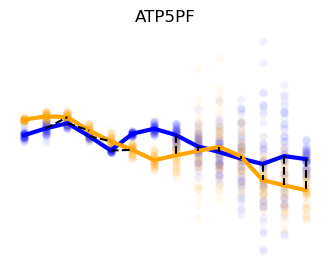

ATP5PD


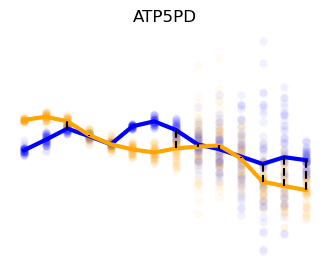

NDUFA6


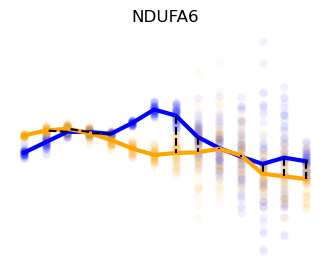

GPX4


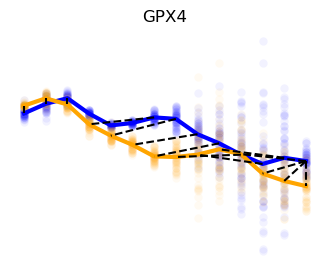

ATP5PB


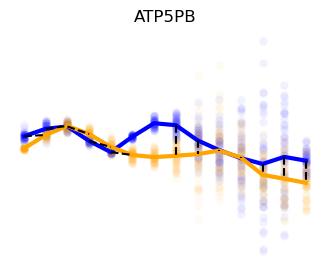

MDH2


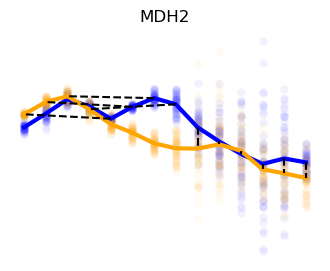

ECH1


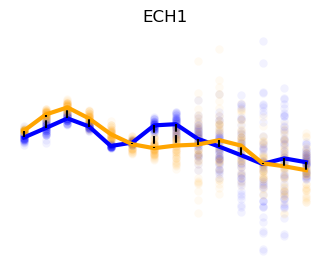

IDH2


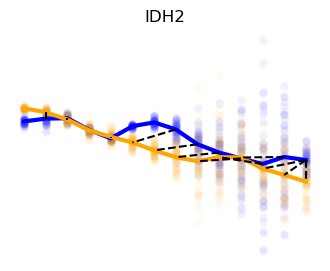

ATP5F1D


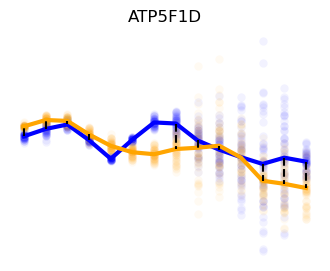

ATP5F1E


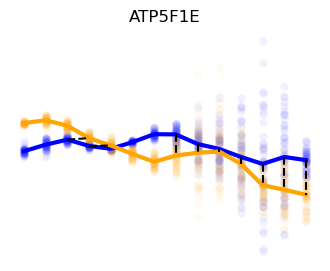

OXA1L


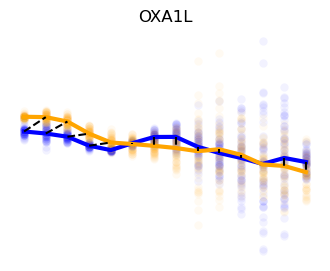

NDUFS6


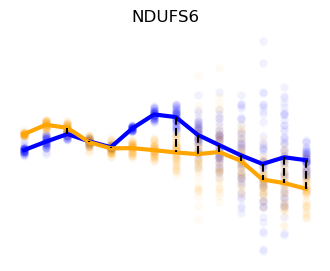

ATP5PO


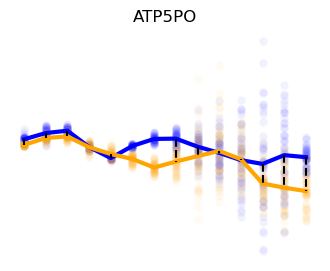

CYCS


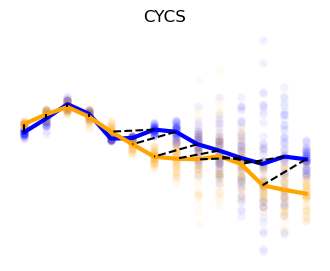

SLC25A5


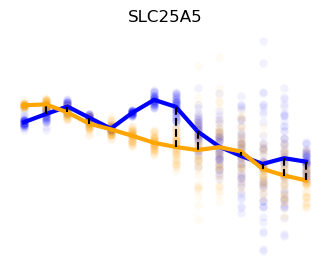

ATP6V0C


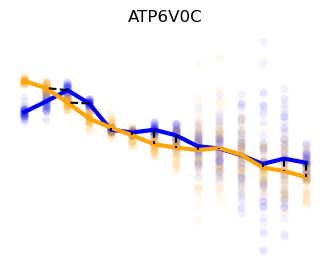

SLC25A11


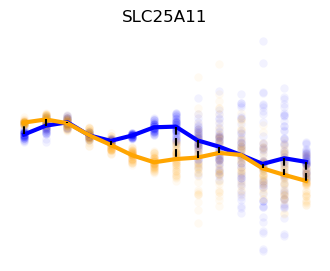

SLC25A6


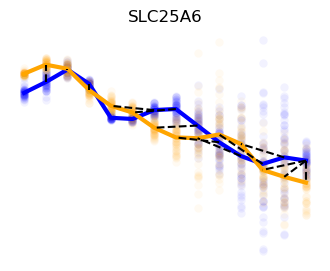

In [120]:
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io


for gene in term_genes_dict["Oxidative Phosphorylation"]:
    print(gene)
    # Redirect the output of the plot function to a StringIO object
    f = io.StringIO()
    with redirect_stdout(f):
        #VisualUtils.plotTimeSeries(gene, aligner, vs)
        #VisualUtils.plotTimeSeriesAlignment(gene, aligner)
        plotTimeSeriesAlignment_cmap(gene, aligner)

    
    # Now, the plot is created and can be saved
    plt.savefig(f"{gene}_time_series_alignment.png", format='png', bbox_inches='tight')
    plt.show() 

# Look for enrichment of CHD genes in any of these groups

In [121]:
chd_genes = pd.read_excel("chdgene_table.xlsx", header=1, index_col=0)
chd_genes

CHD classification  \
Gene                                                          
ABL1                                                ASD,VSD   
ACTC1                                               ASD,VSD   
ACVR1     ASD,AVSD and variants,Malformation of outflow ...   
ACVR2B    ASD with minor abnormalities,VSD with minor ab...   
ADAMTS10                            VSD,Obstructive lesions   
...                                                     ...   
UBR1      ASD with minor abnormalities,VSD with minor ab...   
WASHC5    ASD with minor abnormalities,VSD with minor ab...   
ZEB2      ASD with minor abnormalities,VSD with minor ab...   
ZFPM2                        Malformation of outflow tracts   
ZIC3      ASD with minor abnormalities,VSD with minor ab...   

         Extra cardiac phenotype Inheritance mode  Ranking  \
Gene                                                         
ABL1                         Yes            AD,DN        5   
ACTC1                        Yes               AD        5   
ACVR1                         No            AD,AR        5   
ACVR2B                       Yes               AD        5   
ADAMTS10                     Yes               AR        5   
...                          ...              ...      ...   
UBR1                         Yes            AR,CH        5   
WASHC5                       Yes               AR        5   
ZEB2                         Yes            AD,DN        5   
ZFPM2                         No            AD,DN        5   
ZIC3                         Yes              XLR        5   

          Supporting References  
Gene                             
ABL1                          2  
ACTC1                         3  
ACVR1                         2  
ACVR2B                        2  
ADAMTS10                      2  
...                         ...  
UBR1                          3  
WASHC5                        2  
ZEB2                          3  
ZFPM2                         2  
ZIC3                          5  

[142 rows x 5 columns]

In [122]:
ASD_genes = chd_genes.loc[chd_genes["CHD classification"].str.contains("ASD"),:].index.tolist()
ASD_genes

['ABL1',
 'ACTC1',
 'ACVR1',
 'ACVR2B',
 'ANKRD11',
 'ARID1A',
 'ARID1B',
 'B3GAT3',
 'BCOR',
 'BMPR2',
 'BRAF',
 'CDK13',
 'CHD4',
 'CHD7',
 'CHST14',
 'CITED2',
 'CREBBP',
 'DNAH11',
 'DNAH5',
 'EFTUD2',
 'ELN',
 'EVC',
 'EVC2',
 'FGFR2',
 'FLNA',
 'FOXC1',
 'FOXP1',
 'GATA4',
 'GATA5',
 'GATA6',
 'GLI3',
 'GPC3',
 'HAAO',
 'HDAC8',
 'HNRNPK',
 'HRAS',
 'KANSL1',
 'KAT6A',
 'KAT6B',
 'KDM2B',
 'KDM6A',
 'KMT2A',
 'KMT2D',
 'KRAS',
 'KYNU',
 'LTBP2',
 'LZTR1',
 'MAP2K1',
 'MAP2K2',
 'MED12',
 'MEIS2',
 'MYBPC3',
 'MYH6',
 'MYH7',
 'NF1',
 'NIPBL',
 'NKX2-5',
 'NODAL',
 'NONO',
 'NOTCH2',
 'NPHP3',
 'NR2F2',
 'NSD1',
 'PBX1',
 'PIGV',
 'PITX2',
 'PTPN11',
 'RAB23',
 'RAF1',
 'RERE',
 'RIT1',
 'SALL1',
 'SETD5',
 'SHOC2',
 'SMAD2',
 'SMAD4',
 'SMARCA4',
 'SMARCB1',
 'SMARCE1',
 'SMC1A',
 'SMC3',
 'SON',
 1,
 'STRA6',
 'TAB2',
 'TBX20',
 'TBX5',
 'TGFBR1',
 'TGFBR2',
 'THOC6',
 'TLL1',
 'TMEM260',
 'TRAF7',
 'TXNL4A',
 'UBR1',
 'WASHC5',
 'ZEB2',
 'ZIC3']

In [123]:
all_CHD_genes = chd_genes.index.tolist()

In [124]:
df['CHD_associated'] = False
df.loc[df['Gene'].isin(all_CHD_genes),'CHD_associated'] = True
df

Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
102     PITX2                             0.0          72.073285  5.087232   
1325    VASH2                             0.0          72.073285  5.029911   
839     PANCR                             0.0          72.073285  4.983164   
1254     NAV3                             0.0          72.073285   2.77465   
1385      NTM                             0.0          72.073285 -2.679169   
...       ...                             ...                ...       ...   
615      AFF4                             1.0           8.596102 -0.021425   
54       PJA2                             1.0          24.350768  0.017249   
220     ERBIN                             1.0          17.282821  0.015276   
715   ANKRD12                             1.0           13.57806  0.007043   
1156     UBR5                             1.0          10.355713  0.002385   

      color  abs_l2fc trajectory       trend  CHD_associated  
102     red  5.087232       LaCM  Unchanging            True  
1325    red  5.029911       LaCM  Increasing           False  
839     red  4.983164       LaCM  Unchanging           False  
1254    red   2.77465       LaCM  Unchanging           False  
1385    red  2.679169       RaCM  Increasing           False  
...     ...       ...        ...         ...             ...  
615   green  0.021425     Common  Increasing            True  
54    green  0.017249     Common  Unchanging           False  
220   green  0.015276     Common  Unchanging           False  
715   green  0.007043     Common  Unchanging           False  
1156  green  0.002385     Common  Increasing           False  

[1546 rows x 9 columns]

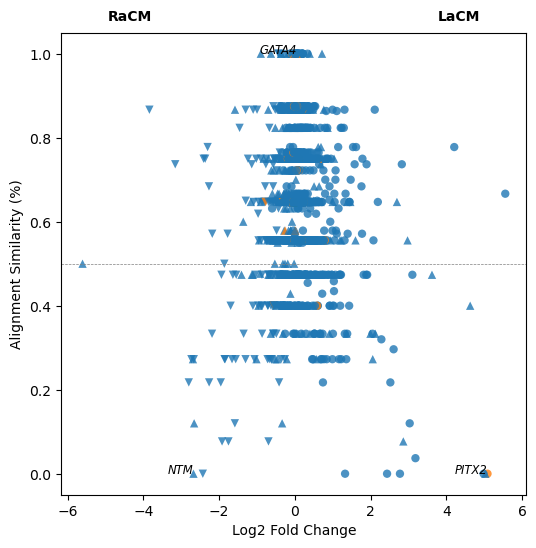

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

markers = {
    "Increasing":"^",
    "Decreasing":"v",
    "Unchanging":"o"
}

#y_axis = 'opt_alignment_cost'
y_axis = 'alignment_similarity_percentage'

sns.scatterplot(data=df, x='l2fc', y=y_axis, hue='CHD_associated', edgecolor="none",
                style = 'trend', markers = markers,
                legend=False, alpha=0.8)

# Add a horizontal line at y=0.5
plt.axhline(0.5, color='gray', linestyle='--', linewidth = 0.5)

# Add text annotations for LaCM and RaCM
plt.text(0.1, 1.05, 'RaCM', transform=plt.gca().transAxes, ha='left', va='top', weight='semibold')
plt.text(0.9, 1.05, 'LaCM', transform=plt.gca().transAxes, ha='right', va='top', weight='semibold')

# Label specific genes
for gene in genes_of_interest:
    gene_data = df[df['Gene'] == gene]
    for _, row in gene_data.iterrows():
        plt.text(row['l2fc'], row[y_axis], gene, 
                 horizontalalignment='right', size='small', color='black', weight='regular', style='italic')

# Set labels
plt.xlabel("Log2 Fold Change")

if y_axis == "alignment_similarity_percentage":
    plt.ylabel("Alignment Similarity (%)")

if y_axis == "opt_alignment_cost":
    plt.ylabel("Alignment Cost (nits)")

# Save the plot
#plt.savefig("similarity_v_logFC.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

<Axes: xlabel='trajectory', ylabel='alignment_similarity_percentage'>

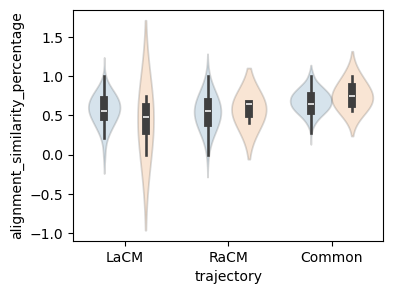

In [126]:
#sns.stripplot(data = df, x = 'CHD_associated', y = 'alignment_similarity_percentage', hue = 'CHD_associated', legend=False, jitter=0.05, alpha = 0.1)
sns.violinplot(data = df, x = 'trajectory', y = 'alignment_similarity_percentage', hue = 'CHD_associated', legend=False, alpha = 0.2, bw_adjust=2)

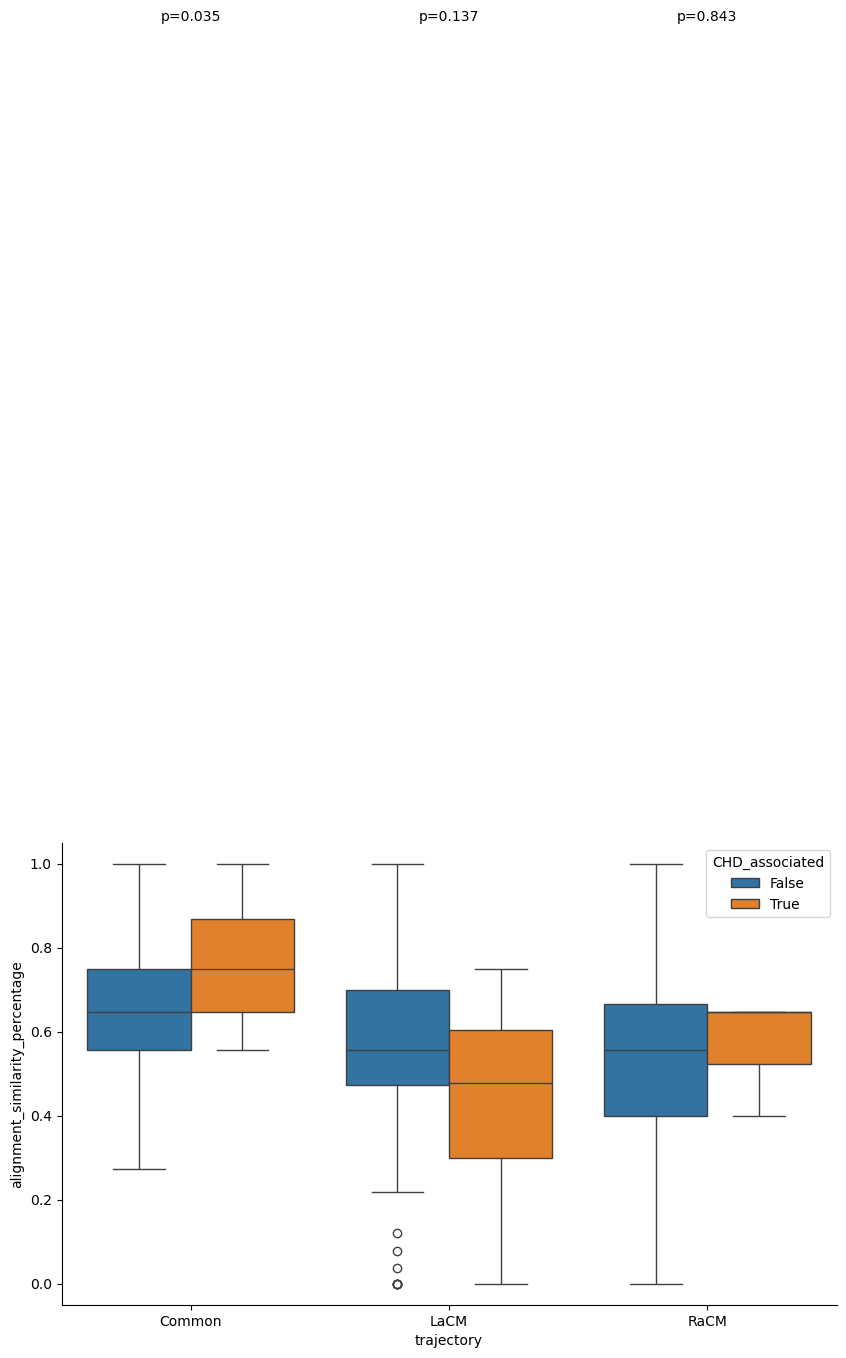

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Your DataFrame manipulation and t-test code here
df['alignment_similarity_percentage'] = pd.to_numeric(df['alignment_similarity_percentage'], errors='coerce')

# Define the trajectories to be tested
trajectories = ['Common', 'LaCM', 'RaCM']
p_values = {}

# Perform t-tests and store p-values in a dictionary with trajectories as keys
for trajectory in trajectories:
    group1 = df[(df['trajectory'] == trajectory) & (df['CHD_associated'] == True)]['alignment_similarity_percentage'].dropna()
    group2 = df[(df['trajectory'] == trajectory) & (df['CHD_associated'] == False)]['alignment_similarity_percentage'].dropna()
    t_stat, p_value = stats.ttest_ind(group1, group2)
    p_values[trajectory] = p_value

# Plotting the violin plot
plt.figure(figsize=(10,6))
#ax = sns.violinplot(data=df, x='trajectory', y='alignment_similarity_percentage', hue='CHD_associated', alpha=0.2, bw_adjust=2, order=trajectories)
ax = sns.boxplot(data=df, x='trajectory', y='alignment_similarity_percentage', hue='CHD_associated', order=trajectories)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Function to add significance text
def add_significance_text(x_pos, y, text, color='k'):
    plt.text(x_pos, y, text, ha='center', va='bottom', color=color)

# Adding the statistical annotations
y_max = df['alignment_similarity_percentage'].max()
h = 2  # Offset for the annotation

# Annotate each group with its corresponding p-value
for i, trajectory in enumerate(trajectories):
    p_value = p_values[trajectory]
    p_text = f"p={p_value:.2e}" if p_value < 0.001 else f"p={p_value:.3f}"
    add_significance_text(i, y_max + h, p_text)


plt.show()


MSigDB_Hallmark_2020


Gene_set                               Term Overlap   P-value  \
0  MSigDB_Hallmark_2020           PI3K/AKT/mTOR  Signaling   4/105  0.001709   
2  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   5/200  0.002914   
1  MSigDB_Hallmark_2020            Estrogen Response Early   5/200  0.002914   
3  MSigDB_Hallmark_2020             Estrogen Response Late   4/200  0.016340   
4  MSigDB_Hallmark_2020                         Myogenesis   4/200  0.016340   
5  MSigDB_Hallmark_2020              Inflammatory Response   4/200  0.016340   
7  MSigDB_Hallmark_2020                     UV Response Dn   3/144  0.032994   
8  MSigDB_Hallmark_2020                Allograft Rejection   3/200  0.073491   
9  MSigDB_Hallmark_2020                  KRAS Signaling Up   3/200  0.073491   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.027200            0                     0    8.432663   
2          0.027200            0                     0    5.492754   
1          0.027200            0                     0    5.492754   
3          0.076253            0                     0    4.324556   
4          0.076253            0                     0    4.324556   
5          0.076253            0                     0    4.324556   
7          0.115480            0                     0    4.473065   
8          0.205774            0                     0    3.192461   
9          0.205774            0                     0    3.192461   

   Combined Score                            Genes  n_genes  
0       53.730318           ITPR2;PITX2;PLCB1;EGFR        4  
2       32.067417   SFRP1;CXCL12;PRRX1;CDH11;INHBA        5  
1       32.067417  FARP1;CXCL12;SLC24A3;NAV2;DHRS3        5  
3       17.791858         FARP1;CXCL12;SLC24A3;CKB        4  
4       17.791858               GJA5;FHL1;NAV2;CKB        4  
5       17.791858        PCDH7;KCNMB2;INHBA;DCBLD2        4  
7       15.259509                PLCB4;PRKCE;MAGI2        3  
8        8.334232                 TGFB2;INHBA;EGFR        3  
9        8.334232               PRRX1;INHBA;DCBLD2        3

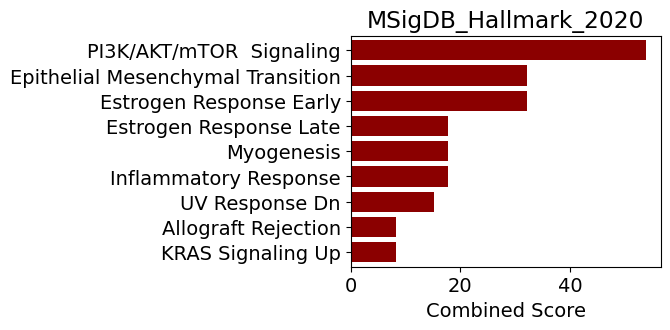

KEGG_2021_Human


Gene_set                                               Term  \
28  KEGG_2021_Human                             Long-term potentiation   
29  KEGG_2021_Human                          Thyroid hormone synthesis   
30  KEGG_2021_Human                               Long-term depression   
31  KEGG_2021_Human                              Glutamatergic synapse   
34  KEGG_2021_Human                                  Insulin secretion   
35  KEGG_2021_Human                                       Gap junction   
37  KEGG_2021_Human                                 Salivary secretion   
38  KEGG_2021_Human                             GnRH signaling pathway   
32  KEGG_2021_Human                 Vascular smooth muscle contraction   
33  KEGG_2021_Human                           Apelin signaling pathway   
40  KEGG_2021_Human                              Circadian entrainment   
42  KEGG_2021_Human   Inflammatory mediator regulation of TRP channels   
41  KEGG_2021_Human                Aldosterone synthesis and secretion   
44  KEGG_2021_Human  AGE-RAGE signaling pathway in diabetic complic...   
50  KEGG_2021_Human                                     GnRH secretion   
51  KEGG_2021_Human                   Cortisol synthesis and secretion   
45  KEGG_2021_Human                                         Amoebiasis   
46  KEGG_2021_Human  Parathyroid hormone synthesis, secretion and a...   
54  KEGG_2021_Human                                    Renin secretion   
36  KEGG_2021_Human                         Oxytocin signaling pathway   
47  KEGG_2021_Human                               Serotonergic synapse   
59  KEGG_2021_Human                             Gastric acid secretion   
43  KEGG_2021_Human                         cGMP-PKG signaling pathway   
48  KEGG_2021_Human                  Thyroid hormone signaling pathway   
39  KEGG_2021_Human                          Calcium signaling pathway   
52  KEGG_2021_Human                               Dopaminergic synapse   
53  KEGG_2021_Human                         Estrogen signaling pathway   
56  KEGG_2021_Human                             Spinocerebellar ataxia   
63  KEGG_2021_Human                         TGF-beta signaling pathway   
57  KEGG_2021_Human                  Phospholipase D signaling pathway   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
28    5/67  0.000018          0.002441            0                     0   
29    5/75  0.000032          0.002441            0                     0   
30    4/60  0.000206          0.008946            0                     0   
31   5/114  0.000234          0.008946            0                     0   
34    4/86  0.000814          0.012690            0                     0   
35    4/88  0.000888          0.012690            0                     0   
37    4/93  0.001091          0.012690            0                     0   
38    4/93  0.001091          0.012690            0                     0   
32   5/133  0.000476          0.012690            0                     0   
33   5/137  0.000545          0.012690            0                     0   
40    4/97  0.001276          0.012690            0                     0   
42    4/98  0.001325          0.012690            0                     0   
41    4/98  0.001325          0.012690            0                     0   
44   4/100  0.001428          0.012854            0                     0   
50    3/64  0.003720          0.023943            0                     0   
51    3/65  0.003886          0.023943            0                     0   
45   4/102  0.001536          0.013059            0                     0   
46   4/106  0.001770          0.014251            0                     0   
54    3/69  0.004597          0.026048            0                     0   
36   5/154  0.000925          0.012690            0                     0   
47   4/113  0.002236          0.017102            0                     0   
59    3/76  0.006019  

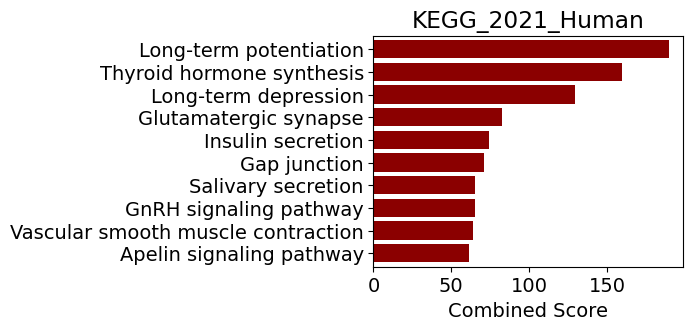

GO_Biological_Process_2023


Gene_set  \
189  GO_Biological_Process_2023   
193  GO_Biological_Process_2023   
192  GO_Biological_Process_2023   
199  GO_Biological_Process_2023   
187  GO_Biological_Process_2023   
182  GO_Biological_Process_2023   
184  GO_Biological_Process_2023   
185  GO_Biological_Process_2023   
188  GO_Biological_Process_2023   
208  GO_Biological_Process_2023   
198  GO_Biological_Process_2023   
213  GO_Biological_Process_2023   
215  GO_Biological_Process_2023   
200  GO_Biological_Process_2023   
191  GO_Biological_Process_2023   
219  GO_Biological_Process_2023   
194  GO_Biological_Process_2023   
222  GO_Biological_Process_2023   
207  GO_Biological_Process_2023   
230  GO_Biological_Process_2023   
232  GO_Biological_Process_2023   
241  GO_Biological_Process_2023   
217  GO_Biological_Process_2023   
249  GO_Biological_Process_2023   
254  GO_Biological_Process_2023   
225  GO_Biological_Process_2023   
260  GO_Biological_Process_2023   
206  GO_Biological_Process_2023   
231  GO_Biological_Process_2023   
240  GO_Biological_Process_2023   

                                                  Term Overlap   P-value  \
189  Negative Regulation Of Sequestering Of Calcium...    3/36  0.000703   
193  Release Of Sequestered Calcium Ion Into Cytoso...    3/39  0.000890   
192                         Odontogenesis (GO:0042476)    3/39  0.000890   
199      SMAD Protein Signal Transduction (GO:0060395)    3/51  0.001946   
187         Positive Regulation Of Growth (GO:0045927)    4/81  0.000650   
182  Modulation Of Chemical Synaptic Transmission (...   5/123  0.000333   
184         Negative Regulation Of Growth (GO:0045926)   5/124  0.000345   
185    Negative Regulation Of Cell Growth (GO:0030308)   5/125  0.000358   
188       Ras Protein Signal Transduction (GO:0007265)   5/144  0.000684   
208     Cellular Response To BMP Stimulus (GO:0071773)    3/66  0.004057   
198  Regulation Of G1/S Transition Of Mitotic Cell ...   4/106  0.001770   
213       Cell-Cell Junction Organization (GO:0045216)    3/68  0.004412   
215           Cell-Cell Junction Assembly (GO:0007043)    3/71  0.004980   
200  Small GTPase Mediated Signal Transduction (GO:...   4/112  0.002164   
191             Regulation Of Cell Growth (GO:0001558)   6/227  0.000837   
219   Calcium Ion Transmembrane Transport (GO:0070588)    3/80  0.006937   
194  Positive Regulation Of GTPase Activity (GO:004...   6/234  0.000980   
222  Calcium Ion Transmembrane Import Into Cytosol ...    3/83  0.007678   
207  Negative Regulation Of Cell Motility (GO:2000146)   4/133  0.004019   
230  Regulation Of Phosphatidylinositol 3-Kinase Si...    3/90  0.009581   
232  Regulation Of Epithelial Cell Proliferation (G...    3/91  0.009874   
241                Cell Junction Assembly (GO:0034329)    3/95  0.011095   
217           Skeletal System Development (GO:0001501)   4/149  0.006000   
249                           Hemopoiesis (GO:0030097)   3/101  0.013083   
254    Positive Regulation Of Cell Growth (GO:0030307)   3/106  0.014886   
225  Negative Regulation Of Cell Migration (GO:0030...   4/163  0.008193   
260                 Calcium Ion Transport (GO:0006816)   3/112  0.017226   
206   Positive Regulation Of MAPK Cascade (GO:0043410)   6/310  0.004014   
231  Cell-Cell Adhesion Via Plasma-Membrane Adhesio...   4/172  0.009848   
240  Positive Regulation Of Hydrolase Activity (GO:...   4/176  0.010649   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
189          0.055687            0                     0   19.216634   
193          0.055687            0                     0   17.612589   
192          0.055687            0                     0   17.612589   
199          0.083249            0                     0   13.201463   
187          0.055687            0                     0   11.074431   
182          0.055687            0                     0    9.112472   
184          0.055687            0                     0    9.035440   
185 

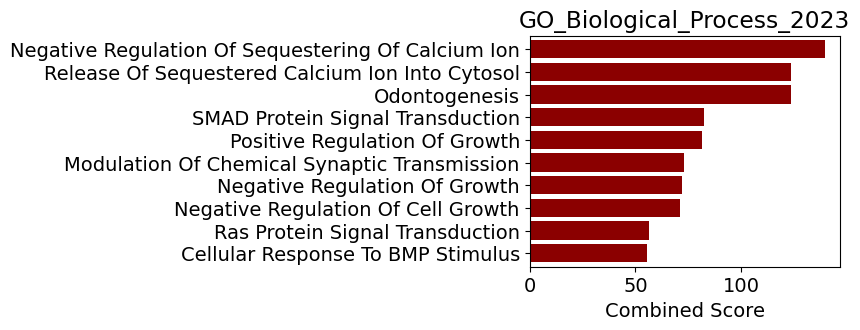

Reactome_2022


Gene_set                                               Term  \
994   Reactome_2022              PLC Beta Mediated Events R-HSA-112043   
995   Reactome_2022             G-protein Mediated Events R-HSA-112040   
999   Reactome_2022       Regulation Of Insulin Secretion R-HSA-422356   
1005  Reactome_2022                      Opioid Signaling R-HSA-111885   
997   Reactome_2022          G Alpha (Q) Signaling Events R-HSA-416476   
1008  Reactome_2022      Integration Of Energy Metabolism R-HSA-163685   
1012  Reactome_2022              Cell-Cell Communication R-HSA-1500931   
1003  Reactome_2022  Platelet Activation, Signaling And Aggregation...   
1024  Reactome_2022                    RHOA GTPase Cycle R-HSA-8980692   
1021  Reactome_2022             GPCR Downstream Signaling R-HSA-388396   
1052  Reactome_2022          G Alpha (I) Signaling Events R-HSA-418594   
1041  Reactome_2022                     Signaling By GPCR R-HSA-372790   
1083  Reactome_2022  Signaling By Receptor Tyrosine Kinases R-HSA-9...   
1118  Reactome_2022       Signaling By Nuclear Receptors R-HSA-9006931   
1040  Reactome_2022                   Signal Transduction R-HSA-162582   
1136  Reactome_2022            Metabolism Of Carbohydrates R-HSA-71387   
1141  Reactome_2022    Extracellular Matrix Organization R-HSA-1474244   
1145  Reactome_2022                      Signaling By WNT R-HSA-195721   
1126  Reactome_2022                            Hemostasis R-HSA-109582   
1156  Reactome_2022  Intracellular Signaling By Second Messengers R...   
1140  Reactome_2022                     RHO GTPase Cycle R-HSA-9012999   
1139  Reactome_2022                  Membrane Trafficking R-HSA-199991   
1159  Reactome_2022           Vesicle-mediated Transport R-HSA-5653656   
1183  Reactome_2022                       Neuronal System R-HSA-112316   
1181  Reactome_2022               Adaptive Immune System R-HSA-1280218   
1184  Reactome_2022                           Metabolism R-HSA-1430728   
1213  Reactome_2022              Signaling By Rho GTPases R-HSA-194315   
1221  Reactome_2022  Signaling By Rho GTPases, Miro GTPases And RHO...   
1234  Reactome_2022                         Axon Guidance R-HSA-422475   
1235  Reactome_2022                              Disease R-HSA-1643685   

      Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
994      3/47  0.001536          0.214785            0                     0   
995      3/52  0.002057          0.214785            0                     0   
999      3/77  0.006241          0.214785            0                     0   
1005     3/88  0.009012          0.214785            0                     0   
997     5/212  0.003738          0.214785            0                     0   
1008    3/105  0.014515          0.258285            0                     0   
1012    3/120  0.020648          0.283401            0                     0   
1003    5/254  0.007938          0.214785            0                     0   
1024    3/147  0.034756          0.283401            0                     0   
1021    7/619  0.030906          0.283401            0                     0   
1052    4/312  0.065360          0.283401            0                     0   
1041    7/689  0.050160          0.283401            0                     0   
1083    5/496  0.093547          0.289291            0                     0   
1118    3/260  0.132492          0.303142            0                     0   
1040  18/2465  0.048740          0.283401            0                     0   
1136    3/285  0.160786          0.319768            0                     0   
1141    3/291  0.167836          0.319768            0                     0   
1145    3/294  0.171395          0.322493            0                     0   
1126    5/576  0.148095          0.314632            0                     0   
1156    3/306  0.185844          0.326082            0                     0   
1140    4/441  0.166482          0.3

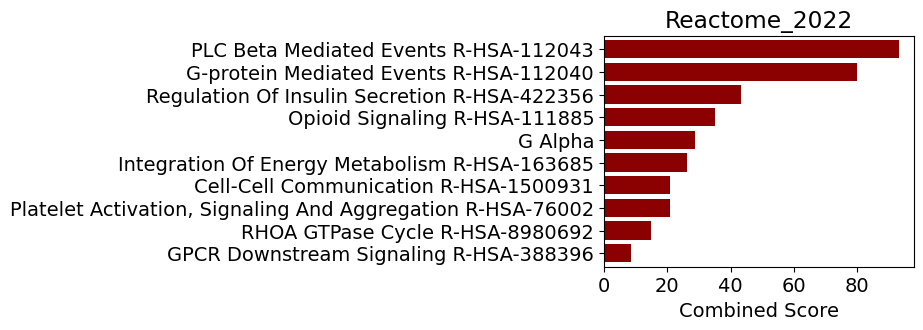

In [206]:
GO_plot(gene_list = topDEgenes[topDEgenes['trajectory']=="LaCM"]['Gene'].tolist(), n_genes=3, display_table=True)

### Clustering genes using their alignments

We first run cluster diagnostics to decide on a distance threshold with a good tradeoff between the number of clusters and the quality of structure. We use levenshtein distance metric

compute distance matrix
using levenshtein distance metric


 78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 77/99 [00:22<00:06,  3.39it/s]


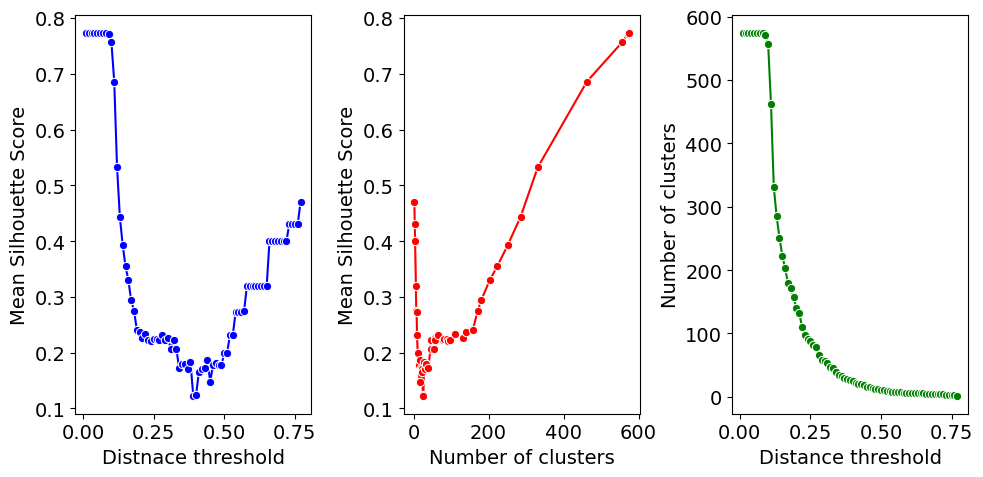

In [472]:
# Running experiment to determine the distance threshold with a good trade-off
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True) 

We can inspect structures of distance thresholds that give local optimals of the mean silhouette score.

In [473]:
df.sort_values('Distance threshold', ascending=False)

Distance threshold  Mean Silhouette Score  Number of clusters
76                0.77               0.469579                 2.0
75                0.76               0.430101                 3.0
74                0.75               0.430101                 3.0
73                0.74               0.430101                 3.0
72                0.73               0.430101                 3.0
..                 ...                    ...                 ...
4                 0.05               0.772962               574.0
3                 0.04               0.772962               574.0
2                 0.03               0.772962               574.0
1                 0.02               0.772962               574.0
0                 0.01               0.772962               574.0

[77 rows x 3 columns]

If we select distance threshold 0.37 which gives a local optimal of 0.3749 silhouette_score with 7 clusters

In [474]:
aligner.show_ordered_alignments()

Gene          Alignment
------------  ----------------------------
PITX2         IIIDIDIDIDIIIIIIIIDDDDDDDDDD
DCBLD2        IIIDIDIDIDIIIIIIIIDDDDDDDDDD
PANCR         IIIDIDIDIDIIIIIIIIDDDDDDDDDD
PCDH7         IIIDIDIDIDIIIIIIIIDDDDDDDDDD
NAV3          IIIDIDIDIDIIIIIIIIDDDDDDDDDD
VASH2         IIIDIDIDIDIIIIIIIIDDDDDDDDDD
NTM           IIIDIDIDIDIIIIIIIIDDDDDDDDDD
ROR1          IIIDIDIDIDIIIIIIIIDDDDDDDDDD
GLCCI1        MMMMMMMMMMMMMM
MORF4L1       MMMMMMMMMMMMMM
PJA2          MMMMMMMMMMMMMM
RO60          MMMMMMMMMMMMMM
NAP1L1        MMMMMMMMMMMMMM
PPP4C         MMMMMMMMMMMMMM
CWC27         MMMMMMMMMMMMMM
MAPKAPK2      MMMMMMMMMMMMMM
MARCH6        MMMMMMMMMMMMMM
AL008730.1    MMMMMMMMMMMVVVDDD
TRIM24        MMMMMMMMMMMMMM
CITED2        MMMMMMMMMMMMMM
CT69          MMMMMMMMMMMMMM
ERBIN         MMMMMMMMMMMMMM
NIBAN1        MMMMMMMMMMMMMM
GATA4         MMMMMMMMMMMMMM
LDHA          MMMMMMMMMMMMMM
GAB1          MMMMMMMMMMMMMM
IDI2-AS1      MMMMMMMMMMMMMM
EXT1          MMMMMMMMMMMMMM
CCDC14

102        PITX2
524       DCBLD2
839        PANCR
1089       PCDH7
1254        NAV3
          ...   
573          UST
9           DOK6
539     RABGAP1L
1267        DGKH
808        PDE1C
Name: genes, Length: 1546, dtype: object

In [586]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.4) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.4
silhouette_score:  0.1241659753131663


Below visualizes all alignment paths in each cluster along with its number of genes 

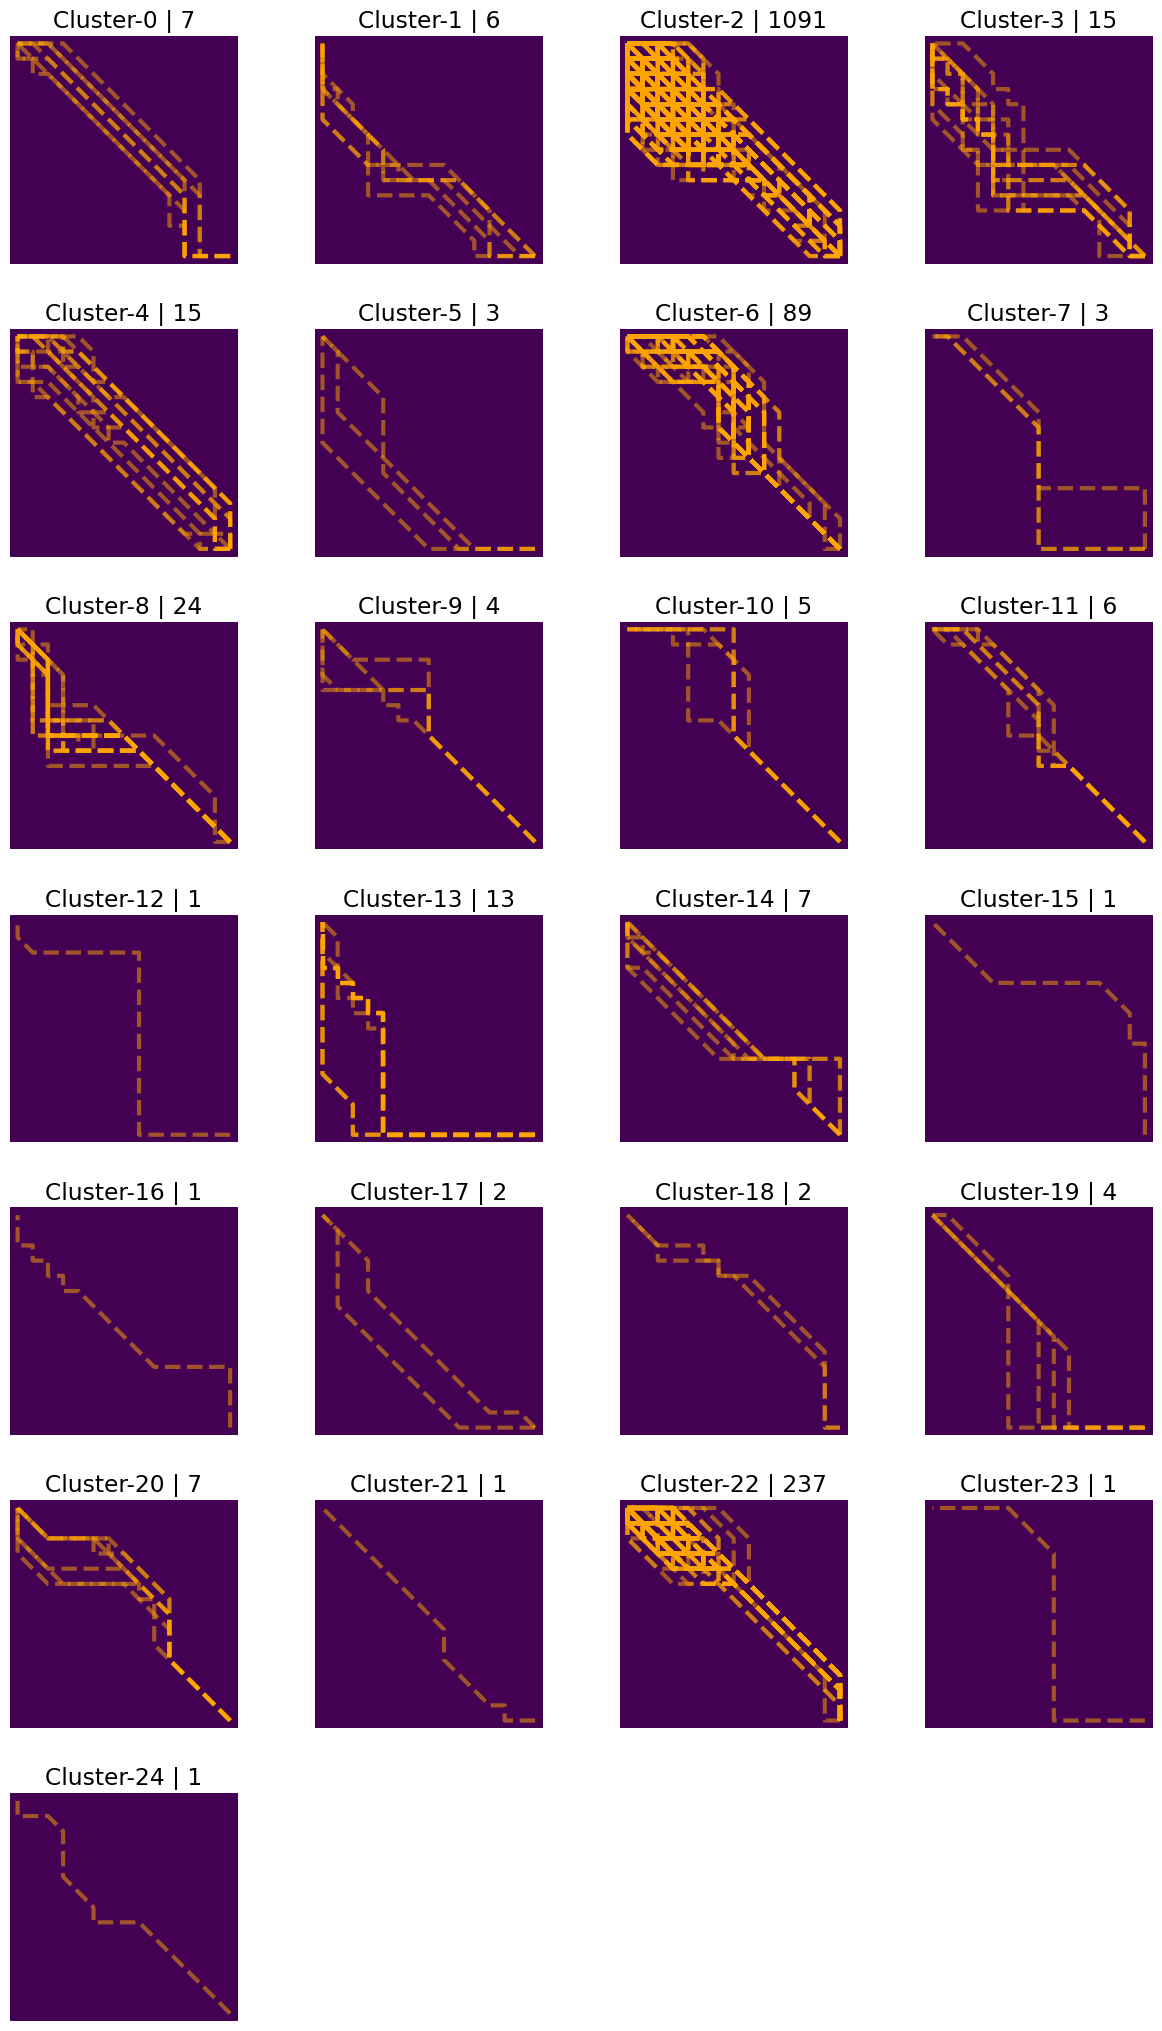

In [587]:
ClusterUtils.visualise_clusters(aligner,n_cols = 4, figsize= (10,6))

In [588]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IIDDMMMMMMMMMVVVDDD 7
cluster:  1 IIIIMMMMIDDDDMMMMMD 6
cluster:  2 IIIDMMMDDMMMMMMMM 1091
cluster:  3 IIIDIDIDIDIIIIIDDDDDDMMMD 15
cluster:  4 IIDDDMMMMMMMIMMMVD 15
cluster:  5 MIIIMMMMMMMMMMWWW 3
cluster:  6 IIDDDDDMMMIIIMMMMMM 89
cluster:  7 IIDMMMMMMVVVVVDDMWWWW 3
cluster:  8 MIIMVVVDDDDDMMMMMMM 24
cluster:  9 IIIDDDMWWWIIIMMMMMMM 4
cluster:  10 IIIDDDDDDMVMVMVMMMMM 5
cluster:  11 IIDDMMMMMVVDDMMMMM 6
cluster:  12 IDDDDDMWWIIIIIIIIIIIIDDDDDD 1
cluster:  13 IIIDIDIDIDIIIIIIIIDDDDDDDDDD 13
cluster:  14 MMMMMMMMMWWWIIIMM 7
cluster:  15 MMMMWWWWWDMMMIDIIIIII 1
cluster:  16 IIIDIDIDMWMMMMWWWWWIIII 1
cluster:  17 MIMMMMMMMMMMMWM 2
cluster:  18 MMIIIDDDDDMMMMMVMVVD 2
cluster:  19 MMMMMMMMVVVVVVDDDDDD 4
cluster:  20 IIMMIDDDDDMMMIMMMVM 7
cluster:  21 MMMMMMMMVIIMMMDDD 1
cluster:  22 IDMMMIDDMMMMMMMMV 237
cluster:  23 DDDDDMMMIIIIIIIIIIDDDMWW 1
cluster:  24 IDDMIIMVMIDDDMMMMMM 1


### Below is the Levenshtein distance heat map of all genes ordered based on the above clustering structure

In [589]:
# Initialize an empty dictionary
cluster_genes_dict = {}

# Loop through each gene and its corresponding cluster ID
for gene, cluster_id in zip(aligner.gene_list, aligner.cluster_ids):
    # Check if the cluster ID is already in the dictionary
    if cluster_id not in cluster_genes_dict:
        # If not, create a new list for this cluster ID
        cluster_genes_dict[cluster_id] = []
    # Append the gene to the list for this cluster ID
    cluster_genes_dict[cluster_id].append(gene)

In [611]:
clus_of_interest=13

In [612]:
cluster_genes_dict[clus_of_interest]
print(len(cluster_genes_dict[clus_of_interest]))

13


Average Alignment:  IIIDIDIDIDIIIIIIIIDDDDDDDDDD


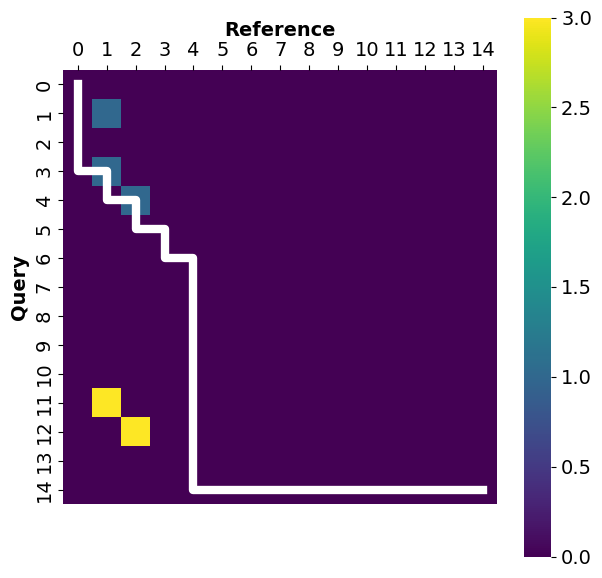

In [613]:
GENE_SUBSET = cluster_genes_dict[clus_of_interest]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

PITX2 IIIDIDIDIDIIIIIIIIDDDDDDDDDD


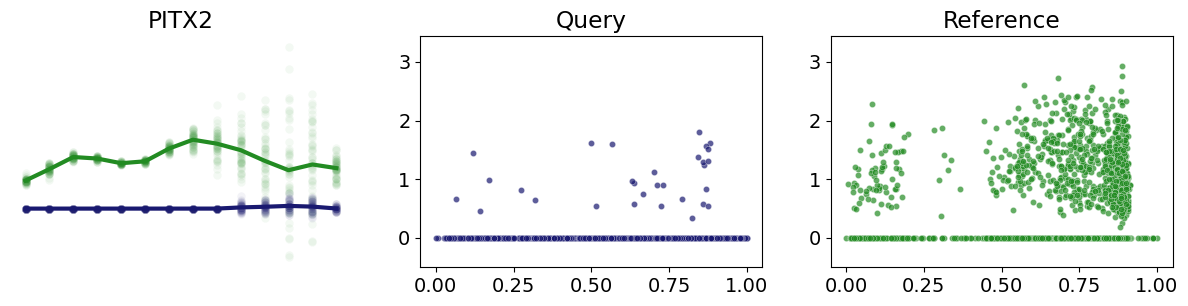

DCBLD2 IIIDIDIDIDIIIIIIIIDDDDDDDDDD


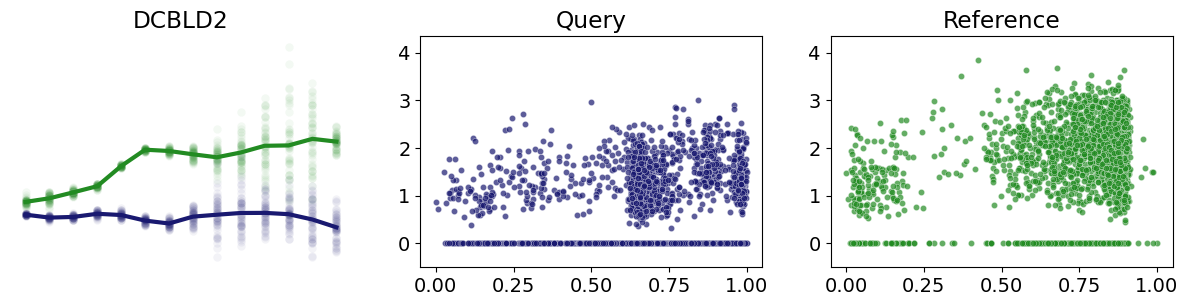

PLCL1 IIMMIDIDIIIIIIIIDDDDDDDDDD


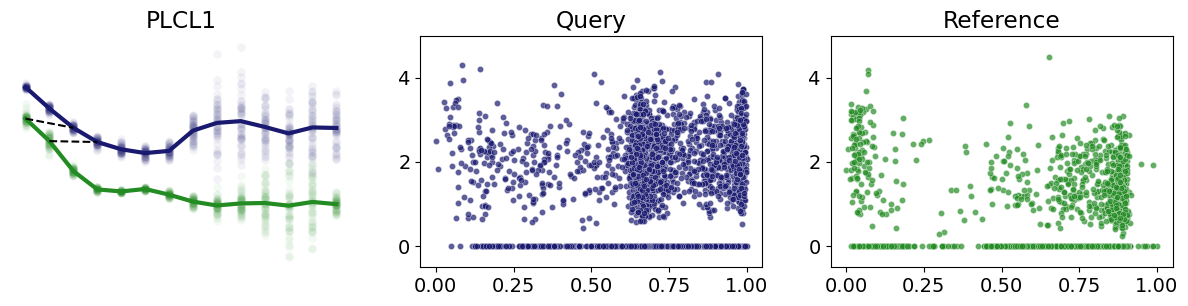

PANCR IIIDIDIDIDIIIIIIIIDDDDDDDDDD


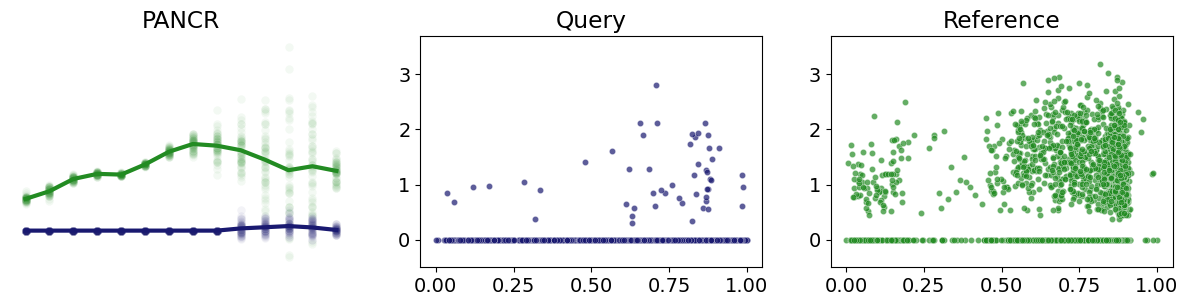

MIR100HG IIIIIIIIIIMMIIDDDDDDDDDDDD


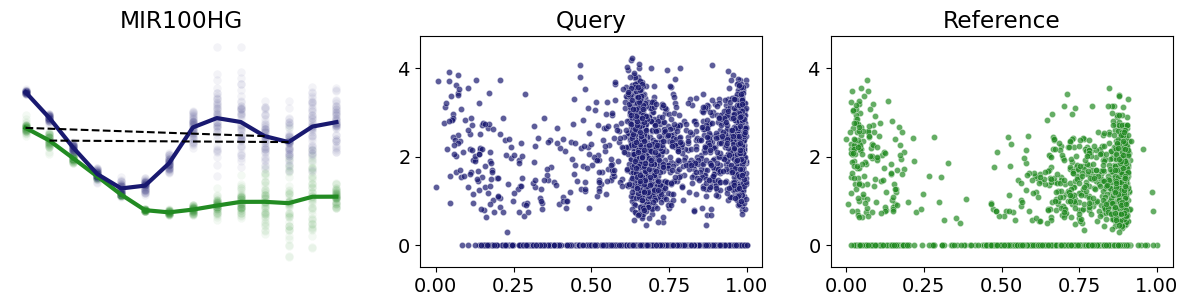

KCNMB2 IIIIIIIIIIMMIIDDDDDDDDDDDD


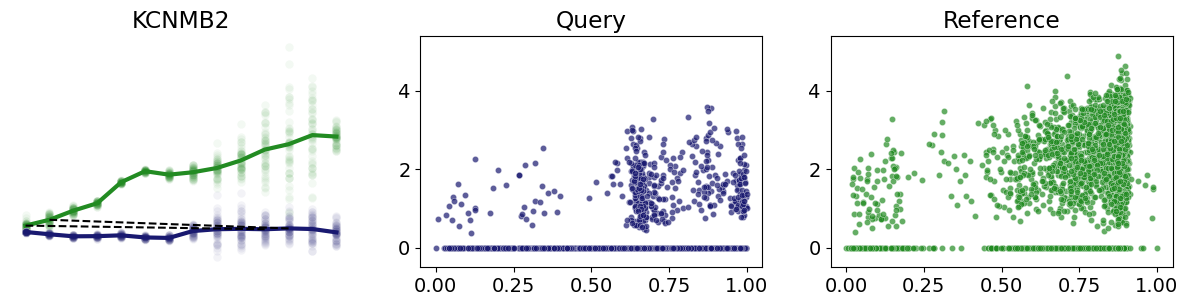

KCNMB2-AS1 MIIIIDIDIDIIIIIIIDDDDDDDDDD


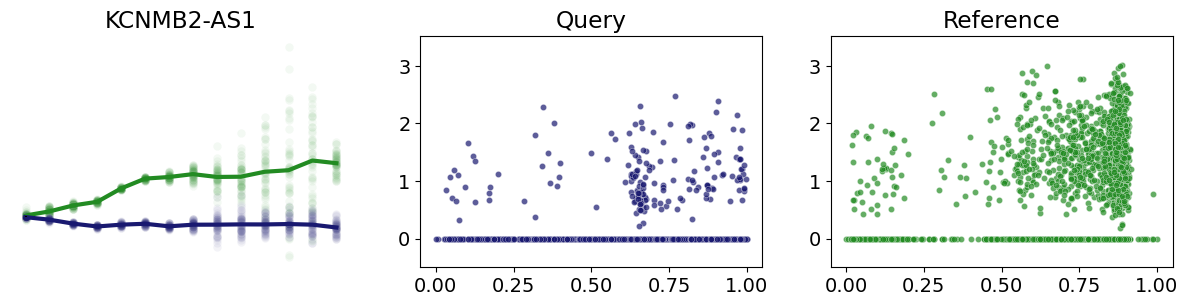

PCDH7 IIIDIDIDIDIIIIIIIIDDDDDDDDDD


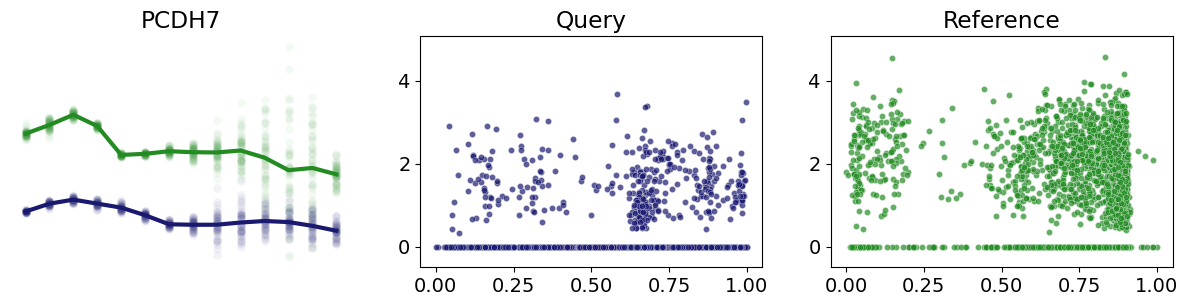

ZNF385B IIIIIIIIIIMMIIDDDDDDDDDDDD


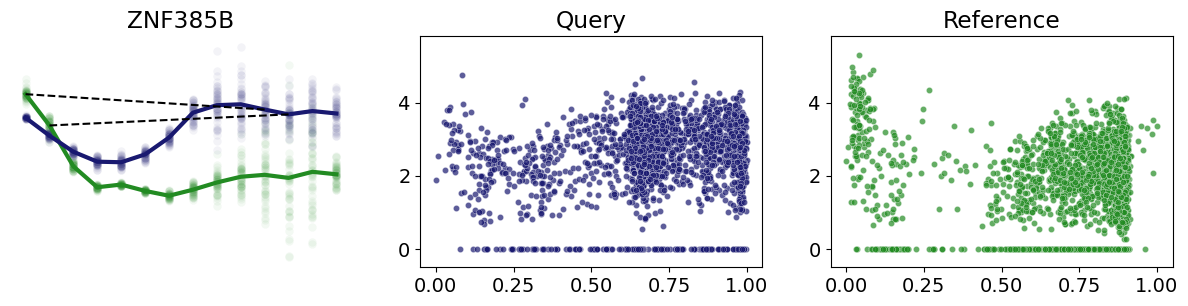

NAV3 IIIDIDIDIDIIIIIIIIDDDDDDDDDD


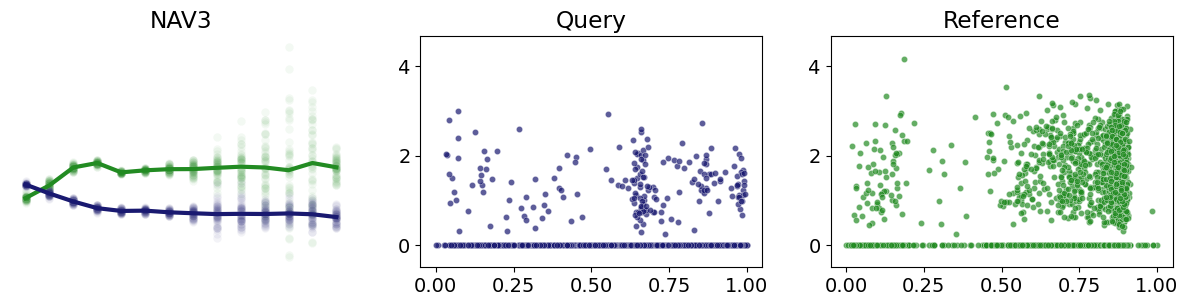

VASH2 IIIDIDIDIDIIIIIIIIDDDDDDDDDD


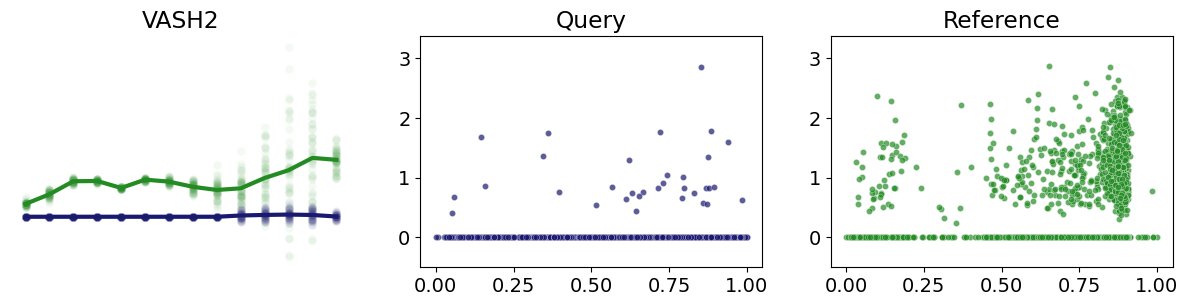

NTM IIIDIDIDIDIIIIIIIIDDDDDDDDDD


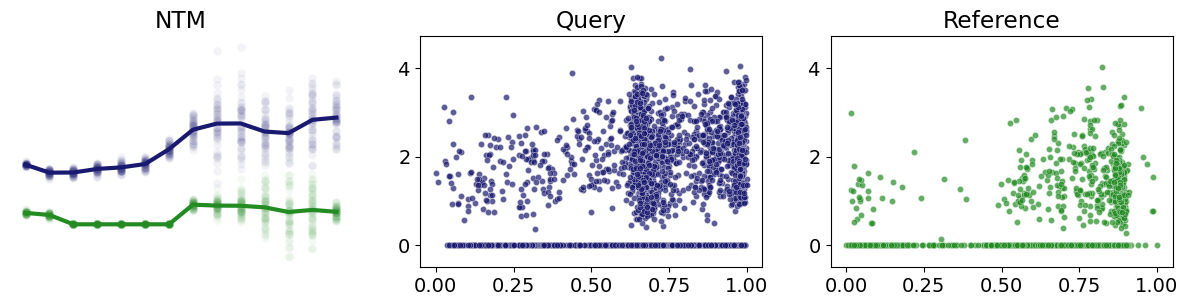

ROR1 IIIDIDIDIDIIIIIIIIDDDDDDDDDD


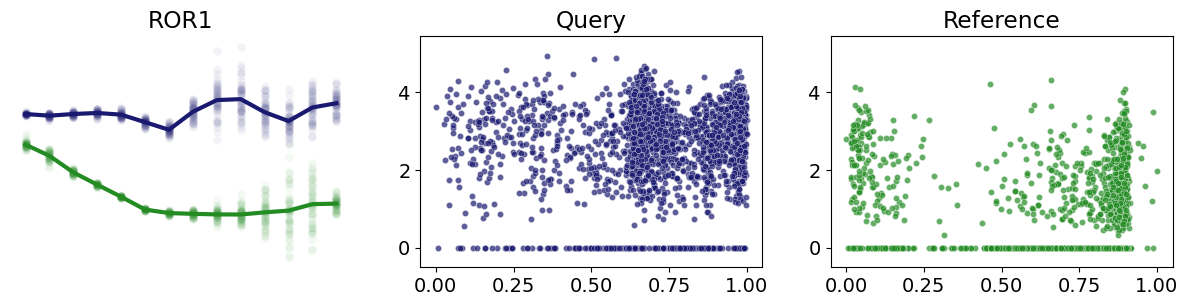

In [614]:
for gene in GENE_SUBSET:
    if len(GENE_SUBSET)<150:
        print(gene, aligner.results_map[gene].alignment_str)
        VisualUtils.plotTimeSeries(gene, aligner, vs)
        plt.show()

In [615]:
import pandas as pd

gene_list = aligner.gene_list
cluster_ids = aligner.cluster_ids

# Convert them into a pandas DataFrame
cluster_df = pd.DataFrame({
    'gene': gene_list,
    'cluster_id': cluster_ids
})


LEFT_genes_set = set(gene_lists['LEFT_genes'])
RIGHT_genes_set = set(gene_lists['RIGHT_genes'])
COMMON_genes_set = set(gene_lists['COMMON_genes'])

# Add columns to cluster_df for LEFT, RIGHT, and COMMON
cluster_df['LEFT'] = cluster_df['gene'].apply(lambda x: x in LEFT_genes_set)
cluster_df['RIGHT'] = cluster_df['gene'].apply(lambda x: x in RIGHT_genes_set)
cluster_df['COMMON'] = cluster_df['gene'].apply(lambda x: x in COMMON_genes_set)

cluster_df

gene  cluster_id   LEFT  RIGHT  COMMON
0      LCLAT1           2   True  False   False
1       MYH7B           2  False  False    True
2      LIMCH1           2  False  False    True
3      SQSTM1           2  False  False    True
4         UTY          19   True  False   False
...       ...         ...    ...    ...     ...
1541      ID2           2  False   True    True
1542   ZNF521           2  False  False    True
1543  NNT-AS1           2  False  False    True
1544    SNU13           2  False  False    True
1545    RNGTT          22  False  False    True

[1546 rows x 5 columns]

In [616]:
n_genes=5

MSigDB_Hallmark_2020


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

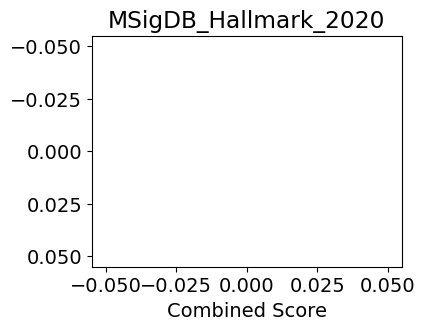

KEGG_2021_Human


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

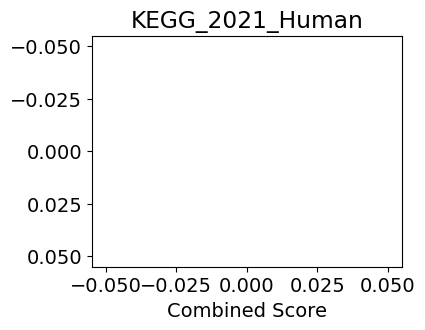

GO_Biological_Process_2023


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

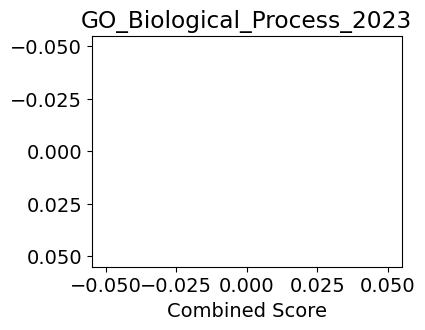

Reactome_2022


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

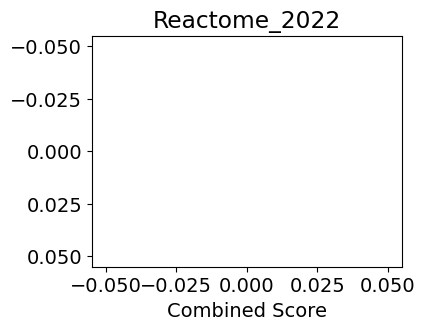

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

In [617]:
list_for_testing = cluster_df[(cluster_df['cluster_id']==clus_of_interest)&(cluster_df['LEFT']==True)].gene.tolist()
GO_plot(gene_list=list_for_testing, display_table=True, n_genes=n_genes)

MSigDB_Hallmark_2020


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

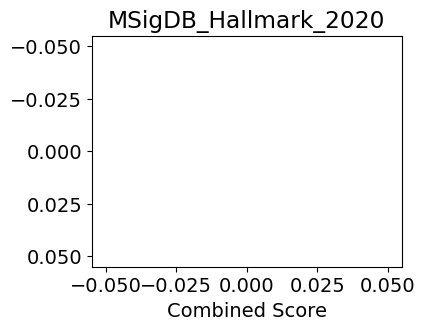

KEGG_2021_Human


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

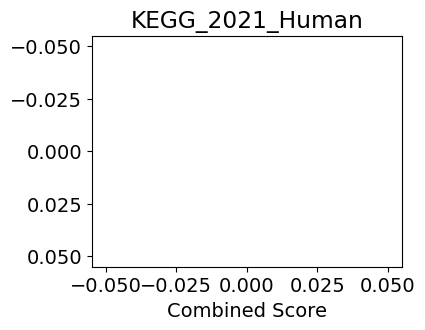

GO_Biological_Process_2023


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

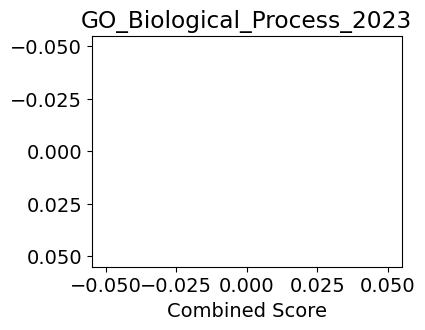

Reactome_2022


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

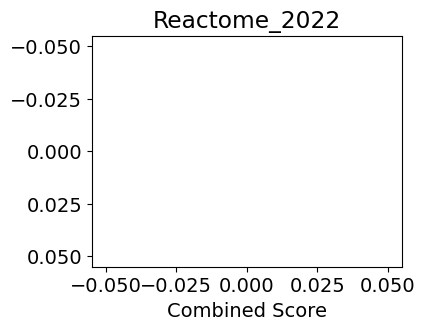

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

In [618]:
list_for_testing = cluster_df[(cluster_df['cluster_id']==clus_of_interest)&(cluster_df['RIGHT']==True)].gene.tolist()
GO_plot(gene_list=list_for_testing, display_table=True, n_genes=n_genes)

MSigDB_Hallmark_2020


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

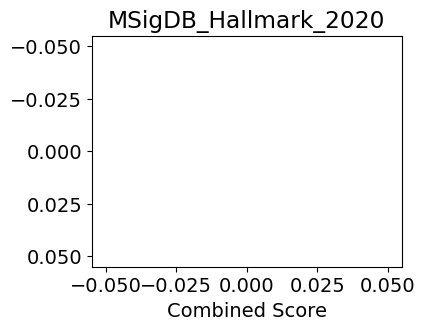

KEGG_2021_Human


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

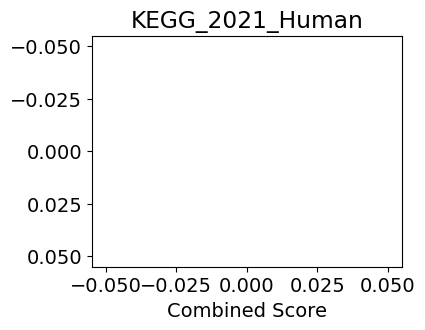

GO_Biological_Process_2023


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

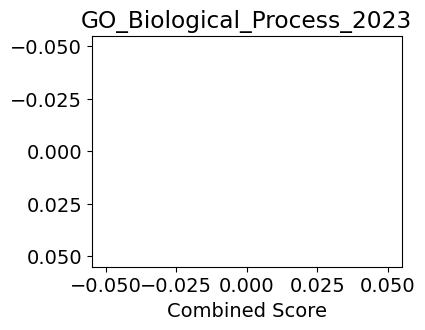

Reactome_2022


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

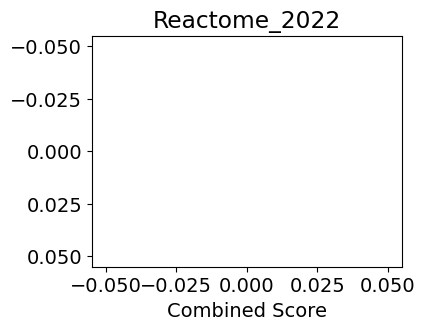

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes, n_genes]
Index: []

In [619]:
list_for_testing = cluster_df[(cluster_df['cluster_id']==clus_of_interest)].gene.tolist()
GO_plot(gene_list=list_for_testing, display_table=True, n_genes=n_genes)